# Bloque #1

In [59]:
'''
from google.colab import drive

drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\n\ndrive.mount('/content/drive')\n"

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import statsmodels.api as sm


#%cd "/content/drive/MyDrive/Inteligencia Artificial"
data = pd.read_csv("dataus2024.csv")
data.shape

(557181, 24)

In [61]:
firms = pd.read_csv('firmsus2024.csv')
firms.shape

(5689, 7)

In [62]:
print(type(data.head()))

<class 'pandas.core.frame.DataFrame'>


In [63]:
# Concat de data con firms para jalar columnas de industria, nombre empresa en data
firms1 = firms[["empresa", "Nombre", "status", "naics1"]]
firms1.columns = ["firm", "Empresa", "status", "industria"]

data = pd.merge(data, firms1, on="firm", how="left")
data.head()

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,originalprice,sharesoutstanding,year,fixedassets,yearf,cto,fiscalq,Empresa,status,industria
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,104.0000,452000.000,2000,NaN,NaN,1,NaN,"Agilent Technologies, Inc",activo,Industrias manufactureras
1,A,2000q2,6.0,4731000.0,2421000.0,1925000.0,73000.0,0.0,0.0,161000.0,...,73.7500,452271.967,2000,1453000.0,2000.0,2,2.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
2,A,2000q3,9.0,7401000.0,3790000.0,3016000.0,101000.0,0.0,0.0,244000.0,...,48.9375,453014.579,2000,1581000.0,2000.0,3,3.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
3,A,2000q4,12.0,10773000.0,5522000.0,4198000.0,111000.0,0.0,0.0,407000.0,...,54.7500,456366.381,2000,1741000.0,2000.0,4,4.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
4,A,2001q1,3.0,2841000.0,1449000.0,1113000.0,19000.0,-25000.0,0.0,119000.0,...,30.7300,456769.737,2001,1821000.0,2001.0,1,1.0,"Agilent Technologies, Inc",activo,Industrias manufactureras


Calculo la variable columna de NetIncome y otras asociadas:

**Utilidad bruta = Gross Profit =** $Revenue - COGS$

**COGS = Cost of Good Sold; son los gastos VARIABLES; cambian con las ventas**

**Utilidad operativa antes de impuesto = Earnings before Onterests and Taxes**

**EBIT (Utilidad Operativa Antes de Impuestos) =** $Gross profit - SGAE$

*SGAE = Safe and General Administrative Expenses

**Net Income =** $EBIT - FINEXP - INCOMETAX + OTHERINCOME + EXTRAORDINARYITEMS$

*FINEXP = Pago de Intereses de Préstamos

*INCOMETAX = Pago de Impuesto Sobre la Renta

*OTHERINCOME = Otras ventas que no sean del core del negocio

*EXTRAORDINARYITEMS = Ventas extraordinarias

*ETB = Utilidad antes de impuesto

*NETINCOME = Utilidad neta, es decir, todas las ganancias menos los gastos


*NOPAT =

In [64]:
data["GROSSPROFIT"] = data["revenue"] - data["cogs"]
data["EBIT"] = data["GROSSPROFIT"] - data["sgae"]
data["NETINCOME"] = data["EBIT"] - data["finexp"] - data["incometax"] + data["otherincome"] + data["extraordinaryitems"]
data["EBT"] = data['EBIT'] - data["finexp"] + data["otherincome"] + data["extraordinaryitems"]
data['Effective_Tax_Rate'] = data['incometax'] / data['EBT']
data['NOPAT'] = data['EBIT'] * (1 - data['Effective_Tax_Rate'])
data['NOPAT'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_26024\2485459827.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['NOPAT'].replace([np.inf, -np.inf], np.nan, inplace=True)


Cálculo de Valor de Mercado y Valor en Libros

Valor de Mercado = MARKET VALUE = $originalprice * sharesoutstanding$
originalprice = precio original de la acción
sharepitstanding = Número de acciones disponibles


Valor en Libros = BOOKVALUE = $totalassets - totalliabilities$

totalassets = total de activos (recursos)

totalliabilities = total de pasivos

In [65]:
data['BOOKVALUE'] = data['totalassets'] - data['totalliabilities']
data['MARKETVALUE'] = data['originalprice'] * data['sharesoutstanding']
data['BOOKMARKET'] = data['BOOKVALUE'] / data['MARKETVALUE']

El BOOK-TO-MARKET es una variable de "Control" que vamos a incluir en el modelo de regresión.

En estadística se le llama variable de control a aquellas variables independientes (explicativas) que en la disciplina de estudio se ha encontrado que tiene mucha correlación con la variable dependiente.

Generamos la $variable / ratio$ de earning per share, que será otra variable de control

**¿Qué es earning per share deflated by price?**

**¿Qué es Earnings?**

Earning se puede medir con alguna variable de utilidad.
Ejemplo:
- NETINCOME
- EBIT (Utilidad Operativa)

**EARNING PER SHARE = EPS =** $EARNINGS / shareoutstanding$

**EARNING PER SHARE DEFLATED BY PRICE = EPSP =** $EPS / originalprice$

In [66]:
data['EPS'] = data['NETINCOME'] / data['sharesoutstanding']
data['EPSP'] = data['EPS'] / data['originalprice']

Ahora calculamos los retornos de acción para todas las empresas (trimestrales y anuales)

**Retorno trimestral = QR =** adjprice / adjprice{t-1} -1

**Retorno anual = YR =** adjprice / adjprice{t-4} - 1

Retornos Continuos Compuestos:

ret trimestral = qr = log(adjprice) - log(adjprice{t-1}) = log(adjprice / adjprice{t-1})

ret anual = yr = log(adjprice) - log(adjprice{t-4})


Genero un úndice en el dataset por firm-quarter:

In [67]:
data['qdate'] = pd.PeriodIndex(data.q, freq = 'Q')
data.set_index(['firm', 'qdate'], inplace = True)
data.head()
data.index

MultiIndex([(     'A', '2000Q1'),
            (     'A', '2000Q2'),
            (     'A', '2000Q3'),
            (     'A', '2000Q4'),
            (     'A', '2001Q1'),
            (     'A', '2001Q2'),
            (     'A', '2001Q3'),
            (     'A', '2001Q4'),
            (     'A', '2002Q1'),
            (     'A', '2002Q2'),
            ...
            ('ZY_old', '2022Q1'),
            ('ZY_old', '2022Q2'),
            ('ZY_old', '2022Q3'),
            ('ZY_old', '2022Q4'),
            ('ZY_old', '2023Q1'),
            ('ZY_old', '2023Q2'),
            ('ZY_old', '2023Q3'),
            ('ZY_old', '2023Q4'),
            ('ZY_old', '2024Q1'),
            ('ZY_old', '2024Q2')],
           names=['firm', 'qdate'], length=557181)

Calcular los CC Returns para cada trimestre y anual de cada firma.

In [68]:
# Quarter returns
data['return_q'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(1))
# Yearly returns
data['return_y'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(4))
print(data.head())

                  q  fiscalmonth     revenue       cogs       sgae  \
firm qdate                                                           
A    2000Q1  2000q1          NaN         NaN        NaN        NaN   
     2000Q2  2000q2          6.0   4731000.0  2421000.0  1925000.0   
     2000Q3  2000q3          9.0   7401000.0  3790000.0  3016000.0   
     2000Q4  2000q4         12.0  10773000.0  5522000.0  4198000.0   
     2001Q1  2001q1          3.0   2841000.0  1449000.0  1113000.0   

             otherincome  extraordinaryitems  finexp  incometax  totalassets  \
firm qdate                                                                     
A    2000Q1          NaN                 NaN     NaN        NaN          NaN   
     2000Q2      73000.0                 0.0     0.0   161000.0    7321000.0   
     2000Q3     101000.0                 0.0     0.0   244000.0    7827000.0   
     2000Q4     111000.0                 0.0     0.0   407000.0    8425000.0   
     2001Q1      19000.0     

Calcule los rendimientos CC returns futuros (un cuarto por delante)

In [69]:
data['return_q_future'] = data.groupby(['firm'])['return_q'].shift(-1)
#data['return_q_future'] = data.groupby(['firm'])['return_q'].shift(-4)

#data['return_y_future'] = data.groupby(['firm'])['return_y'].shift(-1)
data['return_y_future'] = data.groupby(['firm'])['return_y'].shift(-4)

print(data.head())

                  q  fiscalmonth     revenue       cogs       sgae  \
firm qdate                                                           
A    2000Q1  2000q1          NaN         NaN        NaN        NaN   
     2000Q2  2000q2          6.0   4731000.0  2421000.0  1925000.0   
     2000Q3  2000q3          9.0   7401000.0  3790000.0  3016000.0   
     2000Q4  2000q4         12.0  10773000.0  5522000.0  4198000.0   
     2001Q1  2001q1          3.0   2841000.0  1449000.0  1113000.0   

             otherincome  extraordinaryitems  finexp  incometax  totalassets  \
firm qdate                                                                     
A    2000Q1          NaN                 NaN     NaN        NaN          NaN   
     2000Q2      73000.0                 0.0     0.0   161000.0    7321000.0   
     2000Q3     101000.0                 0.0     0.0   244000.0    7827000.0   
     2000Q4     111000.0                 0.0     0.0   407000.0    8425000.0   
     2001Q1      19000.0     

Calcular al menos 4 financial ratios para cada variable independiente que será usada para predecir el futuro stock return

**ROE (Return On Equity):** Ganancias netas / Inversión de capital de accionistas.

Mide rentabilidad y ediciencia de la empresa al momento de generar rendimientos para la inversión de capital de accionistas (eficacia del dinero de los accionistas una empresa para generar ganancias). Mayor ROE = Uso eficiente del capital. Lo escogí debido a que es un indicador directo de la rentabilidad del capital, ya que una empresa con un ROE alto es atractivo a los inversores porque les da a entender que pueden generar beneficios sólidos con sus inversiones.

In [70]:
# Return on Equity (ROE)
data['ROE'] = data['NETINCOME'] / data['BOOKVALUE']
data['ROE'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_26024\702537394.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ROE'].replace([np.inf, -np.inf], np.nan, inplace=True)


**NPM (Net Profit Margin):** Ganancias netas / Ingresos

Mide el porcentaje de ganancias que produce una compañia en comparación con sus ingresos. Tiene un enfoque en la rentabilidad de la empresa. Escogí este ratio debido a que un NPM alto quiere decir que la empresa tiene un buen control de costos y que sus operaciones son eficientes, por lo que puede ser clave para predecir el retorno futuro de las inversiones.

In [71]:
# Net Profit Margin
data['NPM'] = data['NETINCOME'] / data['revenue']
data['NPM'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_26024\3479908675.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['NPM'].replace([np.inf, -np.inf], np.nan, inplace=True)


**ROIC (Return on Invested Capital):** Utilidad operativa neta después de impuestos / Capital invertido

Mide la eficiencia con la que una empresa usa su capital para generar utilidad. Un ROIC alto indica que la empresa está obteniendo un alto rendimiento por cada unidad unidad de capital invertido. Escogí este ratio porque es un indicador de la efectividad con la que una empresa usa su capital total para generar valor. ROIC alto es que una empresa usa su capital de manera eficiente, por lo que puede ser clave para predecir retornos futuros.

In [72]:
# Return on Invested Capital (ROIC)
data['ROIC'] = data['NOPAT'] / data['totalassets']
data['ROIC'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_26024\4238890335.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ROIC'].replace([np.inf, -np.inf], np.nan, inplace=True)


**OPM (Operating Profit Margin):** EBIT / Revenue

Mide el porcentaje de los ingresos que se convierte en utilidades operativas (excluyendo intereses, impuestos, etc). A mayor margen operativo, una empresa es más eficiente de convertir ventas en utilidades (gran capacidad de generar ganancias con las operaciones básicas). Escogí este ratio porque refleja la eficiencia operativa de una empresa, muestra cuánto d elos ingresos se convierten en beneficios operativos. Un OPM alto quiere decir que la empresa tiene control sobre sus costos operativos, lo cual puede ser un factor importante para generar retornos.

In [73]:
# Operating Profit Margin
data['OPM'] = data['EBIT'] / data['revenue']
data['OPM'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_26024\1534909035.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['OPM'].replace([np.inf, -np.inf], np.nan, inplace=True)


**Debt to Equity (DEBTTOEQUITY):** Total Liabilities / Book Value (Equity)

Mide el nivel de endeudamiento financiero de una empresa comparando sus deudas (pasivos totales) con el valor contable de sus activos (patrimonio). Un ratio más alto indica que la empresa está más endeudada en relación con su patrimonio, lo que significa que está financiando sus operaciones principalmente con deuda en lugar de capital propio. Escogí este ratio porque refleja el riesgo financiero de una empresa; una empresa con un alto ratio Debt to Equity puede estar más expuesta a problemas de liquidez y riesgos de insolvencia en tiempos de dificultades económicas, pero también puede beneficiarse de la deuda al generar retornos adicionales a través de inversiones financiadas por esta.

In [74]:
# Debt to Equity
data['DEBTTOEQUITY'] = data['totalliabilities'] / data['BOOKVALUE']
data['DEBTTOEQUITY'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_26024\1656593005.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['DEBTTOEQUITY'].replace([np.inf, -np.inf], np.nan, inplace=True)


**Current Ratio (CURRENTRATIO):**  Current Assets / Current Liabilities

Mide la capacidad de una empresa para pagar sus deudas a corto plazo con sus activos corrientes. Un ratio más alto indica que la empresa tiene suficientes activos líquidos para cubrir sus pasivos inmediatos, lo que sugiere una buena salud financiera en términos de liquidez. Escogí este ratio porque refleja la capacidad de la empresa para manejar sus obligaciones a corto plazo sin necesidad de recurrir a financiación adicional o vender activos importantes. Un Current Ratio bajo podría indicar problemas de liquidez, mientras que un ratio muy alto podría significar que la empresa no está utilizando sus activos de manera eficiente para generar crecimiento o retorno.

In [75]:
# Current Ratio
data['CURRENTRATIO'] = data['currentassets'] / data['currentliabilities']
data['CURRENTRATIO'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\marif\AppData\Local\Temp\ipykernel_26024\753272855.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CURRENTRATIO'].replace([np.inf, -np.inf], np.nan, inplace=True)


### 1.2 Composición firme del mercado financiero estadounidense

1. Empresas activas por industria hay en la muestra

In [76]:
# Filtrar los datos para el último trimestre (trimestre 4) y empresas activas
last_q_data = data[(data['fiscalmonth'] == 4) & (data['status'] == 'activo')]

# Contar cuántas empresas activas hay por industria
active_firms = last_q_data.groupby('industria')['Empresa'].nunique()
print(active_firms)

industria
Comercio al por mayor                                                        1
Comercio al por menor                                                        3
Industrias manufactureras                                                    6
Otros servicios excepto actividades gubernamentales                          1
Servicios de alojamiento temporal y de preparación de alimentos y bebidas    3
Servicios financieros y de seguros                                           1
Name: Empresa, dtype: int64


In [77]:
# Calcular el total de empresas activas en todas las industrias
total_active_firms = active_firms.sum()
print('Total de empresas activas en todas las industrias en el último trimestre:', total_active_firms)

Total de empresas activas en todas las industrias en el último trimestre: 15


2. Tabla de estadísticas sobre el book value y el market value por industria.

In [78]:
# Filtrar los datos para el último trimestre (trimestre 4)
ultimo_trimestre_data = data[data['fiscalmonth'] == 4].copy()

# Calcular las estadísticas para 'BOOKVALUE' y 'MARKETVALUE' por industria
bookvalue_stats = ultimo_trimestre_data.groupby('industria')['BOOKVALUE'].describe()
marketvalue_stats = ultimo_trimestre_data.groupby('industria')['MARKETVALUE'].describe()

# Convertir el resultado de describe a un dataframe. Asignar títulos a las columnas
bookvalue_df = bookvalue_stats.apply(pd.Series).rename(columns=lambda x: f'BOOKVALUE: {x}')
marketvalue_df = marketvalue_stats.apply(pd.Series).rename(columns=lambda x: f'MARKETVALUE: {x}')

# Concatenar los dos df de manera horizontal
statistics = pd.concat([bookvalue_df, marketvalue_df], axis=1)

# Poner a "industria" como columna, no como índice
statistics.reset_index(inplace=True)

# Imprimir el resultado
print(statistics)


                                           industria  BOOKVALUE: count  \
0                              Comercio al por mayor              20.0   
1                              Comercio al por menor              57.0   
2                                       Corporativos               1.0   
3                          Industrias manufactureras              36.0   
4  Minería, explotación de canteras y extracción ...               3.0   
5  Otros servicios excepto actividades gubernamen...               1.0   
6  Servicios de alojamiento temporal y de prepara...              37.0   
7  Servicios de esparcimiento culturales y deport...              10.0   
8                 Servicios financieros y de seguros               3.0   

   BOOKVALUE: mean  BOOKVALUE: std  BOOKVALUE: min  BOOKVALUE: 25%  \
0     1.716400e+06    1.792426e+06      397000.000    7.176922e+05   
1     2.929412e+06    2.823677e+06      106002.000    1.109383e+06   
2     5.000008e+03             NaN        5000.00

**¿Qué se puede decir sobre el tamaño típico de una empresa en términos de valor de mercado y valor contable?**

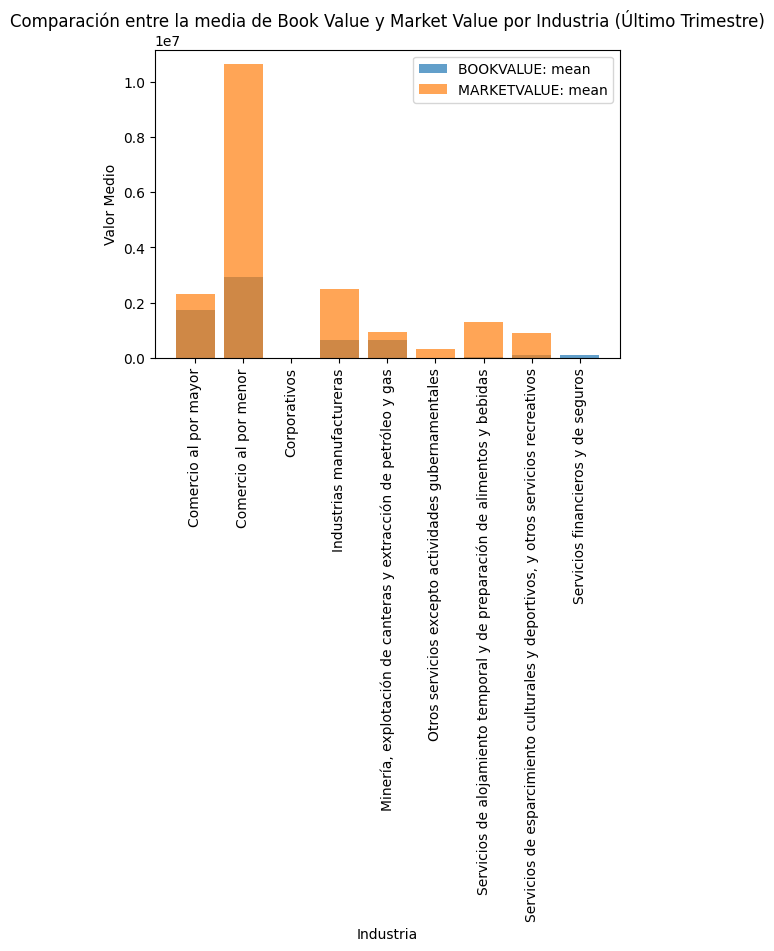

In [79]:
# Calcular la media de BOOKVALUE y MARKETVALUE por industria en el último trimestre
bookvalue_mean = ultimo_trimestre_data.groupby('industria')['BOOKVALUE'].mean().reset_index()
marketvalue_mean = ultimo_trimestre_data.groupby('industria')['MARKETVALUE'].mean().reset_index()
bookvalue_mean = bookvalue_mean.rename(columns={'BOOKVALUE': 'BOOKVALUE_mean'})
marketvalue_mean = marketvalue_mean.rename(columns={'MARKETVALUE': 'MARKETVALUE_mean'})

# Unir ambas medias en un df para graficar
statistics = pd.merge(bookvalue_mean, marketvalue_mean, on='industria')

# Crear la gráfica comparativa de medias
plt.figure(figsize=(6, 4))
plt.bar(statistics['industria'], statistics['BOOKVALUE_mean'], label='BOOKVALUE: mean', alpha=0.7)
plt.bar(statistics['industria'], statistics['MARKETVALUE_mean'], label='MARKETVALUE: mean', alpha=0.7)
plt.xlabel('Industria')
plt.ylabel('Valor Medio')
plt.title('Comparación entre la media de Book Value y Market Value por Industria (Último Trimestre)')
plt.xticks(rotation=90)
plt.legend()
plt.show()

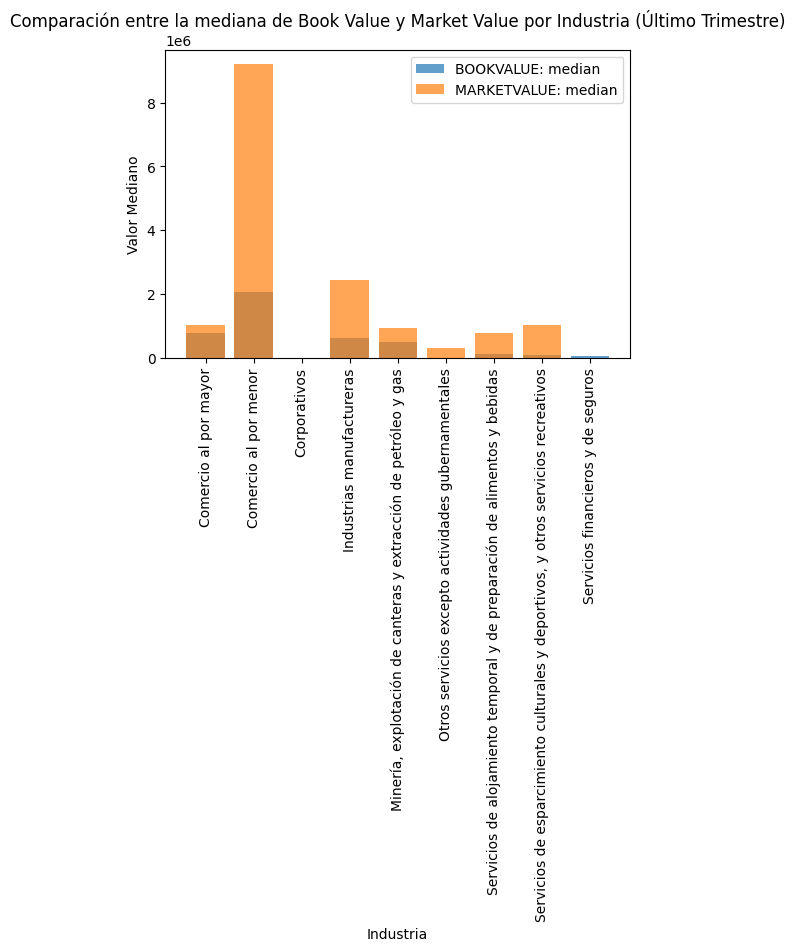

In [80]:
# Calcular la mediana de BOOKVALUE y MARKETVALUE por industria en el último trimestre
bookvalue_median = ultimo_trimestre_data.groupby('industria')['BOOKVALUE'].median().reset_index()
marketvalue_median = ultimo_trimestre_data.groupby('industria')['MARKETVALUE'].median().reset_index()

# Renombrar las columnas para diferenciarlas
bookvalue_median = bookvalue_median.rename(columns={'BOOKVALUE': 'BOOKVALUE_median'})
marketvalue_median = marketvalue_median.rename(columns={'MARKETVALUE': 'MARKETVALUE_median'})

# Unir ambas medianas en un df para graficar
stats_mediana = pd.merge(bookvalue_median, marketvalue_median, on='industria')

# Crear la gráfica comparativa de medianas
plt.figure(figsize=(6, 4))
plt.bar(stats_mediana['industria'], stats_mediana['BOOKVALUE_median'], label='BOOKVALUE: median', alpha=0.7)
plt.bar(stats_mediana['industria'], stats_mediana['MARKETVALUE_median'], label='MARKETVALUE: median', alpha=0.7)
plt.xlabel('Industria')
plt.ylabel('Valor Mediano')
plt.title('Comparación entre la mediana de Book Value y Market Value por Industria (Último Trimestre)')
plt.xticks(rotation=90)
plt.legend()
plt.show()

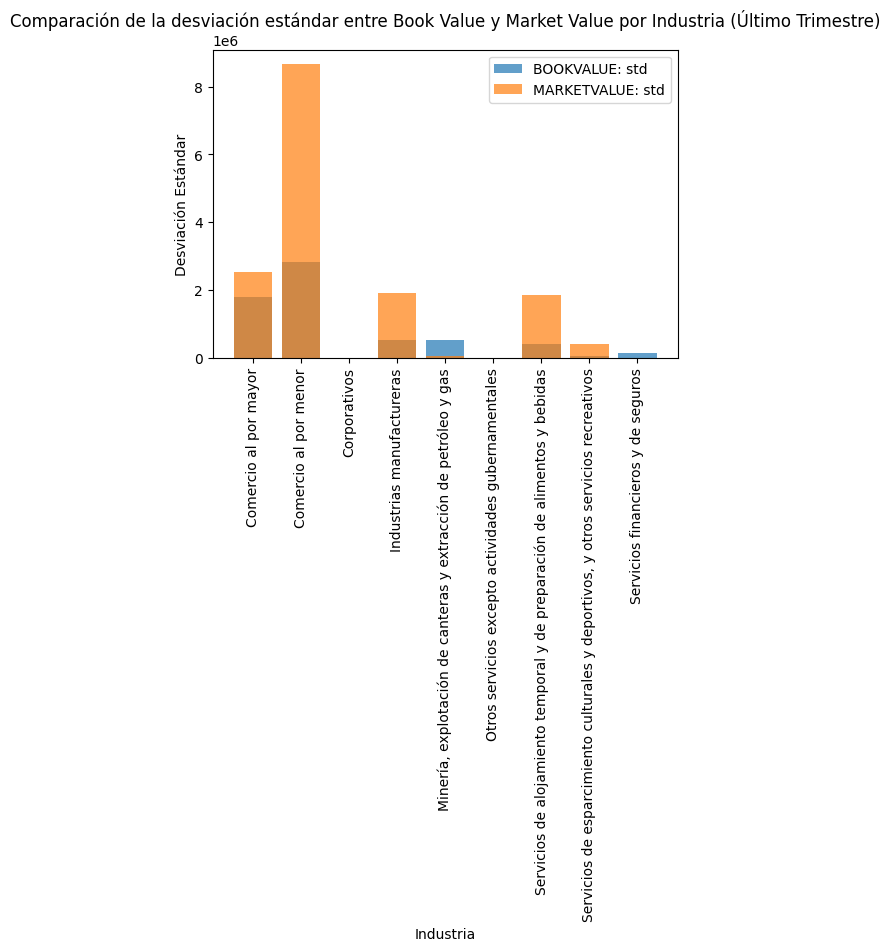

In [81]:
# Calcular la desviación estándar de BOOKVALUE y MARKETVALUE por industria en el último trimestre
bookvalue_std = ultimo_trimestre_data.groupby('industria')['BOOKVALUE'].std().reset_index()
marketvalue_std = ultimo_trimestre_data.groupby('industria')['MARKETVALUE'].std().reset_index()

# Renombrar las columnas para diferenciarlas
bookvalue_std = bookvalue_std.rename(columns={'BOOKVALUE': 'BOOKVALUE_std'})
marketvalue_std = marketvalue_std.rename(columns={'MARKETVALUE': 'MARKETVALUE_std'})

# Unir ambas desviaciones estándar en un df para graficar
statistics_std = pd.merge(bookvalue_std, marketvalue_std, on='industria')

# Crear la gráfica comparativa de desviaciones estándar
plt.figure(figsize=(6, 4))
plt.bar(statistics_std['industria'], statistics_std['BOOKVALUE_std'], label='BOOKVALUE: std', alpha=0.7)
plt.bar(statistics_std['industria'], statistics_std['MARKETVALUE_std'], label='MARKETVALUE: std', alpha=0.7)
plt.xlabel('Industria')
plt.ylabel('Desviación Estándar')
plt.title('Comparación de la desviación estándar entre Book Value y Market Value por Industria (Último Trimestre)')
plt.xticks(rotation=90)
plt.legend()
plt.show()

En la mayoría de las industrias, el Market Value tiende a ser significativamente mayor que el Book Value. Esto podría indicar que el mercado generalmente valora a las empresas más de lo que reflejan sus valores contables. Este fenómeno puede deberse a la expectativa de crecimiento futuro, una fuerte reputación o potencial de generación de ingresos a largo plazo. Sin embargo, la mediana de ambos valores es una medida más representativa para muchas industrias, ya que mitiga el impacto de algunas empresas extremadamente grandes que podrían distorsionar la percepción.

Cuando comparamos la media y la mediana, vemos que la media suele ser mayor en varias industrias, lo que sugiere la presencia de outliers (empresas excepcionalmente grandes) que elevan el valor promedio. Esto también refuerza la idea de que la mediana es una medida más fiable para representar el tamaño típico de una empresa, ya que no se ve tan afectada por esos extremos.

En cuanto a la variabilidad, las diferencias entre el tamaño de las empresas en términos de Market Value son bastante notorias, como lo muestran las gráficas de la desviación estándar. Esto indica que dentro de muchas industrias hay una mezcla de empresas grandes y pequeñas en términos de su valor de mercado. El Book Value, por otro lado, muestra menos variabilidad en algunas industrias, lo que sugiere que las empresas son más similares en cuanto a su valor contable.

En resumen, el Market Value tiende a ser mucho más disperso y está influenciado por las expectativas del mercado y el tamaño relativo de las empresas, mientras que el Book Value es una métrica más estable dentro de cada industria. Dado que el Market Value puede estar distorsionado por unas pocas empresas extremadamente grandes, la mediana es una mejor métrica para describir el tamaño típico de una empresa, minimizando el efecto de los outliers.

**¿Cuánto cambian estas variables dentro de cada industria? :**


El Market Value muestra una gran variabilidad dentro de muchas industrias, lo cual se refleja en las altas desviaciones estándar observadas en las gráficas. Esto sugiere que, dentro de la misma industria, los valores de mercado de las empresas pueden fluctuar considerablemente, con algunas alcanzando valores de mercado muy altos, mientras que otras se mantienen en niveles mucho más bajos. Esta dispersión notable hace que la media no sea siempre un reflejo preciso del tamaño típico de las empresas en la industria, ya que algunas empresas grandes pueden distorsionar el promedio. Por lo tanto, la mediana resulta una medida estadística más representativa para describir el valor de mercado de la mayoría de las empresas, al ser menos sensible a la influencia de estos valores extremos.

En contraste, el Book Value presenta una menor variabilidad entre las empresas de una misma industria, como se evidencia en las desviaciones estándar mucho más bajas en comparación con el Market Value. Esto indica que los valores contables de las empresas son más homogéneos, con menos dispersión alrededor de la media. En este caso, el Book Value tiende a estar más concentrado en un rango estrecho, lo que hace que tanto la media como la mediana sean útiles para representar el valor contable típico. Sin embargo, la mediana sigue siendo una mejor opción cuando hay outliers, ya que minimiza el impacto de empresas con valores contables excepcionalmente altos o bajos.

Por lo tanto, aunque ambas variables presentan fluctuaciones dentro de cada industria, la variabilidad es más pronunciada en el Market Value que en el Book Value. Esto refuerza la necesidad de utilizar la mediana como una medida central más representativa, especialmente para el Market Value, donde las diferencias entre empresas pueden ser más extremas y afectar la interpretación de la media.

**¿Cómo se distribuye el tamaño de la empresa (en valor de mercado)?**

La distribución del tamaño de las empresas, en términos de Market Value, muestra una considerable variabilidad dentro de muchas industrias, como se puede observar en las diferencias entre la media, la mediana y las desviaciones estándar reportadas en los datos. En varias industrias, la media es significativamente mayor que la mediana, lo que sugiere la presencia de un sesgo positivo (a la derecha). Este sesgo indica que, aunque la mayoría de las empresas tienen un valor de mercado relativamente bajo, existen algunas empresas con valores de mercado excepcionalmente altos que elevan la media por encima de la mediana.

Dado este sesgo positivo, la mediana surge como una medida más representativa del tamaño típico de las empresas dentro de cada industria. Al ser menos susceptible a la influencia de estos valores extremos, la mediana proporciona una visión más precisa de la distribución del Market Value, ya que no se ve tan afectada por las pocas empresas que poseen valores de mercado muy altos y que distorsionan la media.

En conclusión, al analizar la distribución del tamaño de las empresas, es preferible utilizar la mediana como métrica principal, ya que ofrece una imagen menos sesgada y más representativa del valor típico de las empresas en cada industria. Esto es particularmente relevante en industrias donde las diferencias entre el Market Value de las empresas son más extremas, como se refleja en las altas desviaciones estándar.

3. ¿Cuáles son las 10 empresas estadounidenses más grandes en términos de valor de mercado y qué tan lejos están del tamaño de mercado típico de una empresa estadounidense?

In [82]:
# Ordenar las empresas por valor de mercado en orden descendente y agrupándolas por empresa (para que no se repitan empresas)
first_10_companies = data.groupby('Empresa')['MARKETVALUE'].sum().sort_values(ascending=False).head(10)

# Tomar los nombres de las primeras 10 empresas
first_10_names = first_10_companies.index

# Filtrar las primeras 10 empresas
first_10_data = data[data['Empresa'].isin(first_10_names)]

# Hacer una tabla con los nombres de las 10 empresas, su industria y su suma de Market value
result = first_10_data.groupby('Empresa').agg({'industria': 'first', 'MARKETVALUE': 'sum'}).sort_values('MARKETVALUE', ascending=False)

# Imprimir las empresas
print(result)


                                                                industria  \
Empresa                                                                     
Apple Inc                                       Industrias manufactureras   
Microsoft Corp                              Información en medios masivos   
Alphabet Inc              Servicios profesionales, científicos y técnicos   
Amazon.Com, Inc                                     Comercio al por menor   
Exxon Mobil Corp                                Industrias manufactureras   
Walmart Inc                                         Comercio al por menor   
Johnson & Johnson                               Industrias manufactureras   
General Electric Company                        Industrias manufactureras   
Meta Platforms, Inc       Servicios profesionales, científicos y técnicos   
Jpmorgan Chase & Co                    Servicios financieros y de seguros   

                           MARKETVALUE  
Empresa                           

In [83]:
# Sumar todos los Market Values de todas las empresas
company_market_values = data.groupby('Empresa')['MARKETVALUE'].sum()
# Calcular el tamaño típico del mercado (con la mediana y no la media porque la media posee muchos outliers, es decir, desviación estándar)
median_market_value = company_market_values.median()
print('Tamaño típico del mercado:', median_market_value)

Tamaño típico del mercado: 34997992.625555396


In [84]:
# Distancia entre el tamaño de mercado típico y el Market Value del top 10 empresas
first_10_companies['distance_from_median'] = first_10_companies - median_market_value
print(first_10_companies['distance_from_median'])

Empresa
Apple Inc                   6.968498e+10
Microsoft Corp              6.807201e+10
Alphabet Inc                4.734901e+10
Amazon.Com, Inc             4.007766e+10
Exxon Mobil Corp            3.377943e+10
Walmart Inc                 2.542652e+10
Johnson & Johnson           2.501088e+10
General Electric Company    2.361824e+10
Meta Platforms, Inc         2.306267e+10
Jpmorgan Chase & Co         2.154043e+10
Name: MARKETVALUE, dtype: float64


In [85]:
# Calcular la diferencia
first_10_companies['percentage_difference'] = ((first_10_companies - median_market_value) / median_market_value)
print(first_10_companies['percentage_difference'])

Empresa
Apple Inc                                                         1991.113744
Microsoft Corp                                                    1945.026045
Alphabet Inc                                                      1352.906426
Amazon.Com, Inc                                                   1145.141538
Exxon Mobil Corp                                                   965.181993
Walmart Inc                                                        726.513811
Johnson & Johnson                                                  714.637545
General Electric Company                                           674.845539
Meta Platforms, Inc                                                658.971147
Jpmorgan Chase & Co                                                615.476192
distance_from_median        Empresa
Apple Inc                   1990.11374...
Name: MARKETVALUE, dtype: object


Al analizar las 10 empresas estadounidenses más grandes en términos de valor de mercado, vemos que están en una liga totalmente distinta comparadas con el tamaño típico de una empresa en el mercado. Por ejemplo, Apple tiene un valor de mercado que es casi 2,000 veces mayor que la mediana del mercado. Esto demuestra que estas empresas, como Apple, Microsoft y Alphabet, concentran una parte enorme del valor total del mercado, lo que refleja una alta concentración y desigualdad.

El hecho de que estas empresas estén tan por encima de la mediana también resalta la importancia de usar la mediana como una mejor medida para representar el tamaño típico de una empresa, porque la media estaría completamente distorsionada por estas gigantes. Además, aunque estas empresas provienen de diferentes industrias, todas comparten la característica de tener un valor de mercado extremadamente alto en comparación con la mayoría de las otras empresas, lo que indica que dentro de sus industrias, son las líderes.

Es por eso que, estas 10 empresas están tan alejadas del tamaño de mercado típico que prácticamente operan en su propio espacio, lo que muestra un mercado muy concentrado donde unas pocas gigantes dominan.Las empresas con un mayor Market Value están alejadas de un 615 hasta un 1991 veces del tamaño típico de una empresa en US (lo cual, es demasiado), por lo que podemos decir que estas son las empresas que forman parte de los outliers de la distribución de MARKETVALUE.

4. ¿Cuáles son las 10 empresas estadounidenses más grandes en términos de valor contable y qué tan lejos están del tamaño contable típico de una empresa estadounidense?

In [86]:
# Ordenar las empresas por Book value en orden descendente y agrupándolas por empresa (para que no sea repitan empresas)
first_10_book = data.groupby('Empresa')['BOOKVALUE'].sum().sort_values(ascending=False).head(10)

# Tomar los nombres de las primeras 10 empresas
first_10_names_book = first_10_book.index

# Filtrar las primeras 10 empresas
first_10_data_book = data[data['Empresa'].isin(first_10_names_book)]

# Hacer una tabla con los nombres de las 10 empresas, su industria y su suma de book value
result_book = first_10_data_book.groupby('Empresa').agg({'industria': 'first', 'BOOKVALUE': 'sum'}).sort_values('BOOKVALUE', ascending=False)

# Imprimir las empresas
print(result_book)

                                                                industria  \
Empresa                                                                     
Berkshire Hathaway Inc                 Servicios financieros y de seguros   
Bank Of America Corp                   Servicios financieros y de seguros   
Jpmorgan Chase & Co                    Servicios financieros y de seguros   
Citigroup Inc                          Servicios financieros y de seguros   
Exxon Mobil Corp                                Industrias manufactureras   
Wells Fargo & Company                  Servicios financieros y de seguros   
Chevron Corp                                    Industrias manufactureras   
AT&T Inc                                    Información en medios masivos   
Alphabet Inc              Servicios profesionales, científicos y técnicos   
General Electric Company                        Industrias manufactureras   

                             BOOKVALUE  
Empresa                           

In [87]:
# Sumar todos los Book Values de todas las empresas
company_book_values = data.groupby('Empresa')['BOOKVALUE'].sum()
# Calcular el tamaño típico del mercado (con la mediana y no la media porque la media posee muchos outliers, es decir, desviación estándar)
median_book_value = company_book_values.median()
print('Tamaño típico del mercado:', median_book_value)

Tamaño típico del mercado: 11830299.0


In [88]:
# Distancia entre el tamaño de mercado típico y el Book Value del top 10 empresas
first_10_book['distance_from_median'] = first_10_book - median_book_value
print(first_10_book['distance_from_median'])

Empresa
Berkshire Hathaway Inc      2.166258e+10
Bank Of America Corp        1.915877e+10
Jpmorgan Chase & Co         1.785957e+10
Citigroup Inc               1.578566e+10
Exxon Mobil Corp            1.416238e+10
Wells Fargo & Company       1.211942e+10
Chevron Corp                1.025700e+10
AT&T Inc                    1.009984e+10
Alphabet Inc                9.293003e+09
General Electric Company    8.575766e+09
Name: BOOKVALUE, dtype: float64


In [89]:
# Calcular diferencia
first_10_book['percentage_difference'] = ((first_10_book - median_book_value) / median_book_value)
print(first_10_book['percentage_difference'])


Empresa
Berkshire Hathaway Inc                                            1831.109991
Bank Of America Corp                                              1619.466482
Jpmorgan Chase & Co                                               1509.646772
Citigroup Inc                                                     1334.341905
Exxon Mobil Corp                                                  1197.127537
Wells Fargo & Company                                             1024.438833
Chevron Corp                                                        867.01069
AT&T Inc                                                           853.726241
Alphabet Inc                                                       785.525622
General Electric Company                                           724.898475
distance_from_median        Empresa
Berkshire Hathaway Inc      1830.10999...
Name: BOOKVALUE, dtype: object


Al observar las 10 empresas estadounidenses más grandes en términos de valor contable (Book Value), queda claro que, al igual que con el valor de mercado, estas empresas están significativamente por encima del tamaño contable típico de una empresa estadounidense. Por ejemplo, Berkshire Hathaway tiene un valor contable que es aproximadamente 1831 veces mayor que la mediana del valor contable en el mercado. Esto indica que estas empresas poseen una cantidad de activos netos muy superior al promedio, lo que las coloca en una posición destacada dentro del mercado.

La mayoría de las empresas en esta lista pertenecen al sector de servicios financieros y de seguros, lo que puede decir que en esta industria se concentran empresas con activos muy grandes en comparación con otras industrias.

Al igual que con el Market Value, la gran diferencia entre la mediana del valor contable y los valores de las empresas más grandes resalta la presencia de outliers significativos en el mercado. Esto reitera la importancia de utilizar la mediana como una medida más representativa del tamaño típico de una empresa, ya que la media sería muy influenciada por estos valores extremos.

Es por eso que, las 10 empresas más grandes en términos de valor contable están a una distancia muy grande del tamaño típico de las empresas en el mercado estadounidense. Esto refleja una gran concentración de activos en unas pocas empresas, especialmente en el sector financiero.

### 1.3 Evolución del mercado financiero de US
Considerando el historial completo de datos financieros de todas las empresas, y solo la información fiscal anual (seleccionando mes fiscal = 12):

1. ¿Cómo ha cambiado el valor total del mercado estadounidense a lo largo de los años? Haz una tabla y/o gráfica y explica:



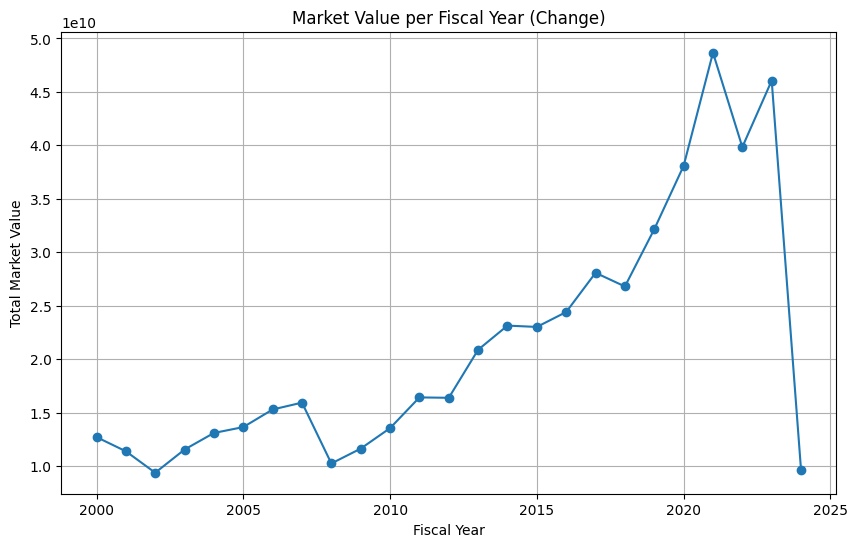

In [90]:
# Crear una columna de 'fiscalyear' desde la columna 'q'
# En la columna 'q' tenemos un formato '2000q1', '2000q2', etc.
data['fiscalyear'] = data['q'].str[:4].astype(int)  # Tomamos los primeros 4 caracteres como año

# Filtrar la información por año fiscal (cuando el mes sea 12)
data_per_year = data[data['fiscalmonth'] == 12]

# Calcular el MARKETVALUE total para cada año fiscal
total_market_value_per_year = data_per_year.groupby('fiscalyear')['MARKETVALUE'].sum()

# Tabla por año fiscal de Market Value
mkt_val_by_year = total_market_value_per_year.reset_index()
mkt_val_by_year.columns = ['Fiscal Year', 'Market Value']

# Mostrar gráfica por año fiscal
plt.figure(figsize=(10, 6))
plt.plot(mkt_val_by_year['Fiscal Year'], mkt_val_by_year['Market Value'], marker='o', linestyle='-')
plt.xlabel('Fiscal Year')
plt.ylabel('Total Market Value')
plt.title('Market Value per Fiscal Year (Change)')
plt.grid(True)
plt.show()


Esta gráfica nos cuenta la trayectoria de cómo ha cambiado el valor total del mercado estadounidense a lo largo de los años. Desde el 2000 hasta 2021, podemos ver un crecimiento bastante constante en el valor del mercado. Aunque hubo algunas caídas y subidas pequeñas, la tendencia general fue hacia arriba, lo que muestra un mercado en expansión, con empresas cada vez más costosas.

En 2021, el mercado alcanzó un pico importante, probablemente impulsado por el auge de las empresas tecnológicas (debido a la pandemia y la digitalización de los negocios) y otros factores. Sin embargo, después de este pico, hay una caída bastante drástica, especialmente hacia 2024. Esta caída podría deberse a una corrección del mercado, problemas económicos o cambios en las políticas que afectaron el valor de las empresas.

La gráfica también destaca períodos de estabilidad, como entre 2010 y 2015, donde el crecimiento fue más moderado, reflejando un mercado más estable durante esos años.

En resumen, el valor total del mercado estadounidense creció de manera sólida durante dos décadas, alcanzó su punto más alto en 2021, pero luego experimentó una caída significativa, recordándonos lo volátil que puede ser el mercado financiero.

2. ¿Cómo han cambiado a lo largo de los años los ingresos totales y los ingresos netos totales de todas las empresas estadounidenses? Haz una tabla y/o gráfica y explica

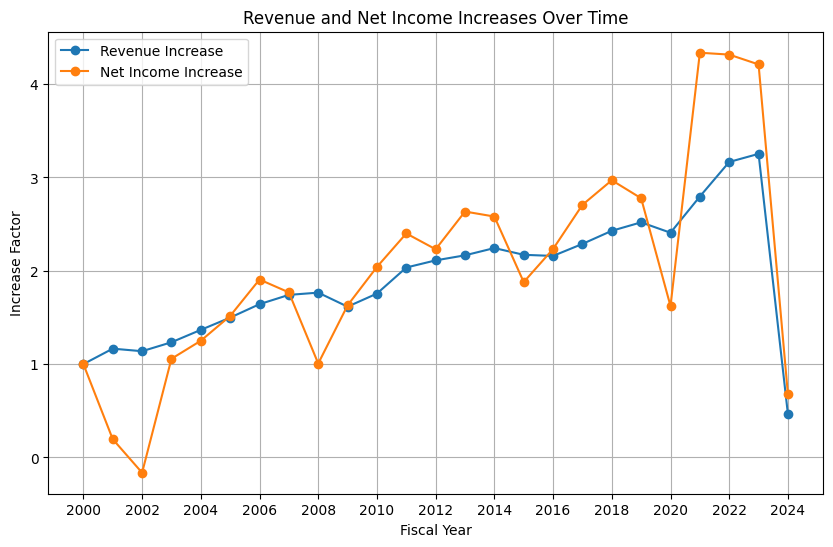

In [91]:
# Calcular el factor de incremento dividiendo cada valor por el primer valor de cada columna
total_revenue_per_year = data_per_year.groupby('fiscalyear').agg({'revenue': 'sum', 'NETINCOME': 'sum'}).reset_index()
total_revenue_per_year.columns = ['Fiscal Year', 'Revenue', 'Net Income']

# Calcular el incremento de Market Value
mkt_val_by_year['Market Value Increase'] = mkt_val_by_year['Market Value'] / mkt_val_by_year.iloc[0]['Market Value']
# Calcular el incremento de Revenue
total_revenue_per_year['Revenue Increase'] = total_revenue_per_year['Revenue'] / total_revenue_per_year.iloc[0]['Revenue']
# Calcular el incremento de Net Income
total_revenue_per_year['Net Income Increase'] = total_revenue_per_year['Net Income'] / total_revenue_per_year.iloc[0]['Net Income']

# Graficar los factores de incremento
plt.figure(figsize=(10, 6))
plt.plot(total_revenue_per_year['Fiscal Year'], total_revenue_per_year['Revenue Increase'], marker='o', linestyle='-', label='Revenue Increase')
plt.plot(total_revenue_per_year['Fiscal Year'], total_revenue_per_year['Net Income Increase'], marker='o', linestyle='-', label='Net Income Increase')
plt.xlabel('Fiscal Year')
plt.ylabel('Increase Factor')
plt.title('Revenue and Net Income Increases Over Time')
plt.legend()

# Ajustar los ticks del eje x para mostrar solo cada dos años
plt.xticks(mkt_val_by_year['Fiscal Year'][::2])

plt.grid(True)
plt.show()


A lo largo de los años, tanto los ingresos totales como los ingresos netos de las empresas estadounidenses han tenido cambios significativos. En general, ambos han mostrado un crecimiento sostenido desde el año 2000, lo que refleja un desempeño financiero positivo en el mercado.

Sin embargo, los ingresos netos han sido mucho más volátiles que los ingresos totales. Por ejemplo, en los primeros años, se puede ver que los ingresos netos cayeron considerablemente antes de volver a subir. Esta fluctuación sugiere que factores como cambios en costos, impuestos, o ganancias excepcionales han tenido un impacto más fuerte en las ganancias netas de las empresas.

Un gran punto a considerar es el aumento significativo en los ingresos netos alrededor de 2021, que incluso superó al incremento en los ingresos totales. Este pico podría haber sido impulsado por cambios en costos, activos, o cambios causados por la pandemia y su notable reducción de costos operativos y de packaging, a pesar de que los ingresos generales no crecieran al mismo ritmo.

Sin embargo, después de 2021, tanto los ingresos totales como los ingresos netos comenzaron a disminuir de manera notable, llegando a niveles cercanos a los del año 2000 hacia 2024. Esta caída podría estar relacionada con alguna crisis económica derivada al regreso de la pandemia así como que para el 2024 aún no tenemos los datos completos porque aún no termina.

### 1.4 Aprender sobre una industria

Industria seleccionada: Manufacturing industries

#### 1.4.1 Estadísticas descriptivas para su industria
Usando la submuestra de la industria "Manufacturing industries" y usando información fiscal anual (seleccionando filas con mes fiscal = 12) y el año completo más reciente (2023), haga lo siguiente:

- Muestre estadísticas descriptivas para el rendimiento de registro anual futuro, activos totales, ingresos, ingresos netos, variables de control y todos los índices financieros seleccionados. Proporcionar una interpretación clara de las estadísticas descriptivas de ingresos y 1 ratio financiero.

In [92]:
# Filtrar empresas manufactureras por industria en año fiscal
manuf_industry = data[(data['industria'] == 'Industrias manufactureras') &
                      (data['fiscalmonth'] == 12) &
                      (data['year'] == 2023)
]

# Select features
selected_features = ['return_y_future', 'totalassets', 'revenue', 'MARKETVALUE', 'BOOKVALUE', 'NETINCOME', 'ROE', 'NPM', 'ROIC', 'OPM', 'DEBTTOEQUITY', 'CURRENTRATIO', 'NOPAT', 'EBIT', 'BOOKMARKET', 'currentassets', 'currentliabilities', 'EPSP', 'totalliabilities']

man_ind = manuf_industry[selected_features]

# Descriptive statistics
statistics = man_ind.describe()
print(statistics.round(2))


       return_y_future   totalassets       revenue   MARKETVALUE  \
count           179.00  1.471000e+03  1.471000e+03  1.414000e+03   
mean             -0.05  6.844456e+06  4.656406e+06  1.337376e+07   
std               0.70  2.551226e+07  1.973081e+07  8.527483e+07   
min              -3.24  4.360000e+00 -2.850820e+03  3.842900e+02   
25%              -0.31  9.825300e+04  8.564000e+03  8.802495e+04   
50%               0.09  5.046920e+05  2.687200e+05  7.105686e+05   
75%               0.34  2.732000e+06  2.222889e+06  4.287962e+06   
max               1.42  3.763170e+08  3.832850e+08  2.676737e+09   

          BOOKVALUE    NETINCOME      ROE       NPM     ROIC       OPM  \
count  1.471000e+03      1468.00  1468.00   1272.00  1467.00   1272.00   
mean   2.599635e+06    420341.30    -0.64    -55.30    -0.34    -42.90   
std    1.043731e+07   3246573.63    10.54    916.62     0.92    545.59   
min   -1.722800e+07  -6995000.00  -205.42 -31028.75   -13.08 -16785.75   
25%    2.843750e+

In [93]:
# Calcular promedio ponderado (Sum de Numerador / Sum de Denominador)
weighted_avg_roe = man_ind['NETINCOME'].sum() / man_ind['BOOKVALUE'].sum()
weighted_avg_npm = man_ind['NETINCOME'].sum() / man_ind['revenue'].sum()
weighted_avg_roic = man_ind['NOPAT'].sum() / man_ind['totalassets'].sum()
weighted_avg_opm = man_ind['EBIT'].sum() / man_ind['revenue'].sum()
weighted_avg_d2e = man_ind['totalliabilities'].sum() / man_ind['BOOKVALUE'].sum()
weighted_avg_cr = man_ind['currentassets'].sum() / man_ind['currentliabilities'].sum()

print(f"Promedio Ponderado ROE: {weighted_avg_roe:.4f}")
print(f"Promedio Ponderado NPM: {weighted_avg_npm:.4f}")
print(f"Promedio Ponderado ROIC: {weighted_avg_roic:.4f}")
print(f"Promedio Ponderado OPM: {weighted_avg_opm:.4f}")
print(f"Promedio Ponderado Debt to Equity: {weighted_avg_d2e:.4f}")
print(f"Promedio Ponderado Current Ratio: {weighted_avg_cr:.4f}")

Promedio Ponderado ROE: 0.1614
Promedio Ponderado NPM: 0.0901
Promedio Ponderado ROIC: 0.0629
Promedio Ponderado OPM: 0.1145
Promedio Ponderado Debt to Equity: 1.6329
Promedio Ponderado Current Ratio: 1.4533


- El promedio ponderado del ROE dice que en promedio, las empresas manufactureras están generando un retorno del 16.14% sobre su patrimonio neto, lo cual, es bastante bueno, pues indica que las empresas en esta industria usan eficientemente su capital para generar beneficios. La media del ROE es -0.64, es negativa, así que sugiere que la mayoría de las empresas poseen pérdidas en vez de beneficios. Por otro lado, su mediana es 0, por lo que sugiere que la mayoría de las empresas tienen ROEs cercanos a 0, es decir, que apenas generan beneficios a partir de su patrimonio.

- El promedio ponderado de NPM nos dice que en promedio, las empresas manufactureras obtienen un beneficio de 9 centavos por cada dólar que se ingresa. Esto indica que las empresas pueden obtener una rentabilidad razonable después de cubrir sus gastos. Su media es -55.30, es negativa, así que sugiere que la mayoría de las empresas no obtienen beneficios después de cubrir sus costos. Su mediana es 0, lo que indicaría que la mayoría de las empresas están tienen dificultades para obtener beneficios después de cubrir sus costos.

- El promedio ponderado de ROIC indica que por cada dólar de capital invertido, las empresas manufactureras generan un retorno de 6.29 centavos por cada dólar invertido. La media es -0.34, podemos ver que es negativa, indicando que las empresas no logran generar gran valor sobre el capital invertido. La mediana es -0.03, indicando que la mayoría de las empresas están teniendo rendimientos bajos o nulos sobre el capital invertido.

- El promedio ponderado de OPM dice que las empresas están teniendo un beneficio operativo de 11.45 centavos por dólar de ingresos antes de considerar intereses e impuestos, lo que sugiere que las operaciones manufactureras son algo eficientes. La media es -42.90, es negativa, por lo cual indica que la mayoría de las empresas operan con pérdidas. La mediana es 0.02, es positiva, por lo que indica que muchas de las empresas operan apenas con lo necesario indicando incluso un poco de ineficiencia, al ser un número muy bajo.

- El promedio ponderado de DEBTTOEQUITY dice que las empresas tienen una relación deuda-patrimonio de 1.6329. Esto significa que, por cada dólar de capital propio, las empresas están financiando aproximadamente 1.63 dólares con deuda. Un valor como este sugiere que las empresas están recurriendo a la deuda para financiar sus operaciones y crecimiento en una proporción que es razonable, pero que también puede conllevar un riesgo financiero si las condiciones económicas empeoran. Sin embargo, al observar la media simple de Debt to Equity, que es -0.22, podemos ver una gran diferencia, lo que sugiere que muchas de las empresas tienen una relación negativa o baja, indicando pérdidas netas en términos de patrimonio en comparación con su deuda. La mediana es 2e+05, lo que indica que muchas de las empresas manufactureras tienen un alto nivel de endeudamiento, financiando principalmente con deuda. Esto sugiere que, aunque algunas empresas tienen ratios de deuda manejables, una parte considerable de las empresas en la industria se apalancan fuertemente, lo cual podría implicar riesgos financieros importantes si no logran generar los ingresos necesarios para cubrir sus deudas.

- El promedio ponderado del Current Ratio es 1.4533, lo que indica que, en promedio, las empresas manufactureras tienen aproximadamente 1.45 veces más activos a corto plazo que pasivos a corto plazo. Esto sugiere que las empresas están en una posición razonablemente sólida para cumplir con sus obligaciones a corto plazo, aunque no es un nivel extremadamente alto que garantice una amplia liquidez. La media es 4.41, lo que sugiere que algunas empresas pueden estar manteniendo niveles extremadamente altos de activos a corto plazo en comparación con sus pasivos, lo que podría distorsionar el resultado general. La mediana es 0.02, lo que muestra que una gran parte de las empresas tienen niveles muy bajos de liquidez en relación con sus pasivos a corto plazo. Podría ser indicativo de empresas que enfrentan dificultades para pagar sus deudas inmediatas o que están operando con un alto riesgo de insolvencia a corto plazo.



Con esto en mente, podemos concluir con que los promedios ponderados son significativamente más altos que las medias simples de los ratios, por lo que podemos intuir que las empresas más grandes logran mejores resultados financieros que las empresas pequeñas. Por otro lado, la mediana muestra que muchas de las empresas de la industria manufacturera tienen dificultades financieras, con márgenes operativos y retornos negativos en comparación con el capital. Por ello, el promedio ponderado de todos los ratios es la medida más adecuada para los finantial ratios, pues se muetra el alto impacto de las industrias comparado con el bajo impacto de las industrias pequeñas, dando una visión más clara del desempeño de la industria manufacturera.

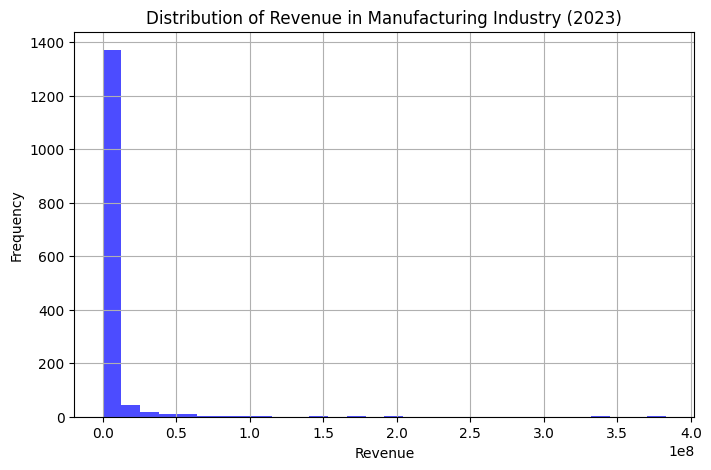

In [94]:
# Revenue
plt.figure(figsize=(8, 5))
plt.hist(man_ind['revenue'].dropna(), bins=30, color='blue', alpha=0.7)
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.title('Distribution of Revenue in Manufacturing Industry (2023)')
plt.grid(True)
plt.show()

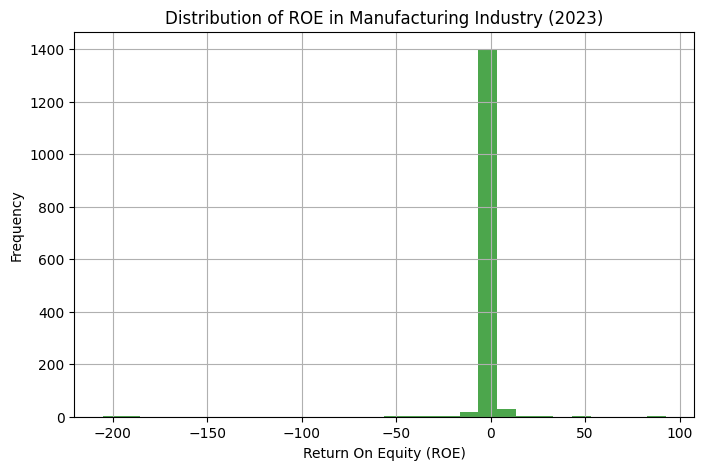

In [95]:
# ROE
plt.figure(figsize=(8, 5))
plt.hist(man_ind['ROE'].dropna(), bins=30, color='green', alpha=0.7)
plt.xlabel('Return On Equity (ROE)')
plt.ylabel('Frequency')
plt.title('Distribution of ROE in Manufacturing Industry (2023)')
plt.grid(True)
plt.show()

**REVENUE**

La gráfica de distribución del revenue en la industria manufacturera para el 2023 muestra una distribución altamente sesgada a la derecha. La mayoría de las empresas en esta industria tienen ingresos significativamente bajos en comparación con las pocas que están en los rangos más altos. Este comportamiento se ve reflejado en las estadísticas descriptivas, donde la mediana del revenue es de aproximadamente $268,720, mientras que algunas empresas alcanzan hasta $383,285,000. La gran diferencia entre la mediana y las cifras más altas indica la presencia de algunas empresas muy grandes que sesgan la distribución.

Este tipo de distribución sugiere que la mayoría de las empresas en la industria manufacturera son pequeñas o medianas, mientras que solo unas pocas generan ingresos extremadamente altos, sesgando la media hacia valores superiores. Por esta razón, es más representativo utilizar la mediana para describir el comportamiento de la mayoría de las empresas en esta industria.

**ROE**

La gráfica del ROE (Retorno sobre el Patrimonio) muestra una distribución donde la gran mayoría de las empresas tienen un ROE cercano a 0, lo que indica que muchas no están generando ganancias significativas en relación con sus fondos propios, o incluso podrían estar operando con pérdidas. Los valores negativos de ROE reflejan posibles problemas financieros o pérdidas sustanciales dentro de la industria. Sin embargo, algunas empresas muestran ROEs considerablemente altos, lo que sugiere que están obteniendo retornos significativos sobre su capital.

En conclusión, la mayoría de las empresas manufactureras generan ingresos relativamente bajos y muestran un ROE bajo, lo que indica que operan con márgenes reducidos y enfrentan dificultades para obtener retornos significativos sobre su capital.


#### 1.4.2 Matriz de correlación

Utilizando datos fiscales anuales (seleccionando filas con mes fiscal = 12) y todos los años:

Muestre una matriz de correlación con las mismas variables que utilizó para las estadísticas descriptivas anteriores, pero en el caso de activos totales, ingresos e ingresos netos, utilice la transformación logarítmica de sus valores. ¿Qué variables tienen una relación lineal más fuerte y significativa con los rendimientos de las acciones (rendimientos anuales)? Explicar

In [96]:
# Filtrar para incluir solo los datos fiscales anuales (mes fiscal = 12) y la industria manufacturera
manuf_industry_fiscal = data[data['fiscalmonth'] == 12].copy()

# Seleccionar las mismas características utilizadas en las estadísticas descriptivas anteriores
selected_features = ['return_y_future', 'totalassets', 'revenue', 'MARKETVALUE', 'BOOKVALUE', 'NETINCOME', 'ROE', 'NPM', 'ROIC', 'OPM', 'DEBTTOEQUITY', 'CURRENTRATIO', 'NOPAT', 'EBIT', 'BOOKMARKET', 'currentassets', 'currentliabilities', 'EPSP']

# Aplicar transformación logarítmica a 'totalassets', 'revenue', 'NETINCOME'
manuf_industry_fiscal['log_totalassets'] = np.log(manuf_industry_fiscal['totalassets'].replace(0, np.nan))
manuf_industry_fiscal['log_revenue'] = np.log(manuf_industry_fiscal['revenue'].replace(0, np.nan))
manuf_industry_fiscal['log_NETINCOME'] = np.log(manuf_industry_fiscal['NETINCOME'].replace(0, np.nan))

# Seleccionar las características transformadas para la matriz de correlación
selected_features_log = ['return_y_future', 'log_totalassets', 'log_revenue', 'MARKETVALUE', 'BOOKVALUE', 'log_NETINCOME', 'ROE', 'NPM', 'ROIC', 'OPM',  'DEBTTOEQUITY', 'CURRENTRATIO', 'BOOKMARKET', 'EPSP']

# Calcular la matriz de correlación usando todos los años
correlation_data = manuf_industry_fiscal[selected_features_log].corr()

# Mostrar la matriz de correlación redondeada a 2 decimales
print(correlation_data.round(2))

# Identificar qué variables tienen una correlación más fuerte con los rendimientos anuales de las acciones
correlation_with_returns = correlation_data['return_y_future'].sort_values(ascending=False)
print("\nCorrelaciones con los rendimientos anuales de las acciones:")
print(correlation_with_returns)


                 return_y_future  log_totalassets  log_revenue  MARKETVALUE  \
return_y_future             1.00             0.14         0.14         0.01   
log_totalassets             0.14             1.00         0.83         0.28   
log_revenue                 0.14             0.83         1.00         0.27   
MARKETVALUE                 0.01             0.28         0.27         1.00   
BOOKVALUE                   0.02             0.39         0.33         0.54   
log_NETINCOME               0.01             0.83         0.81         0.34   
ROE                        -0.01            -0.02         0.01         0.00   
NPM                         0.03             0.06         0.16         0.01   
ROIC                        0.03            -0.02         0.00         0.00   
OPM                         0.03             0.06         0.17         0.01   
DEBTTOEQUITY                0.01            -0.00        -0.01        -0.00   
CURRENTRATIO               -0.06            -0.16   

c:\Users\marif\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\marif\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Correlation Matriz')

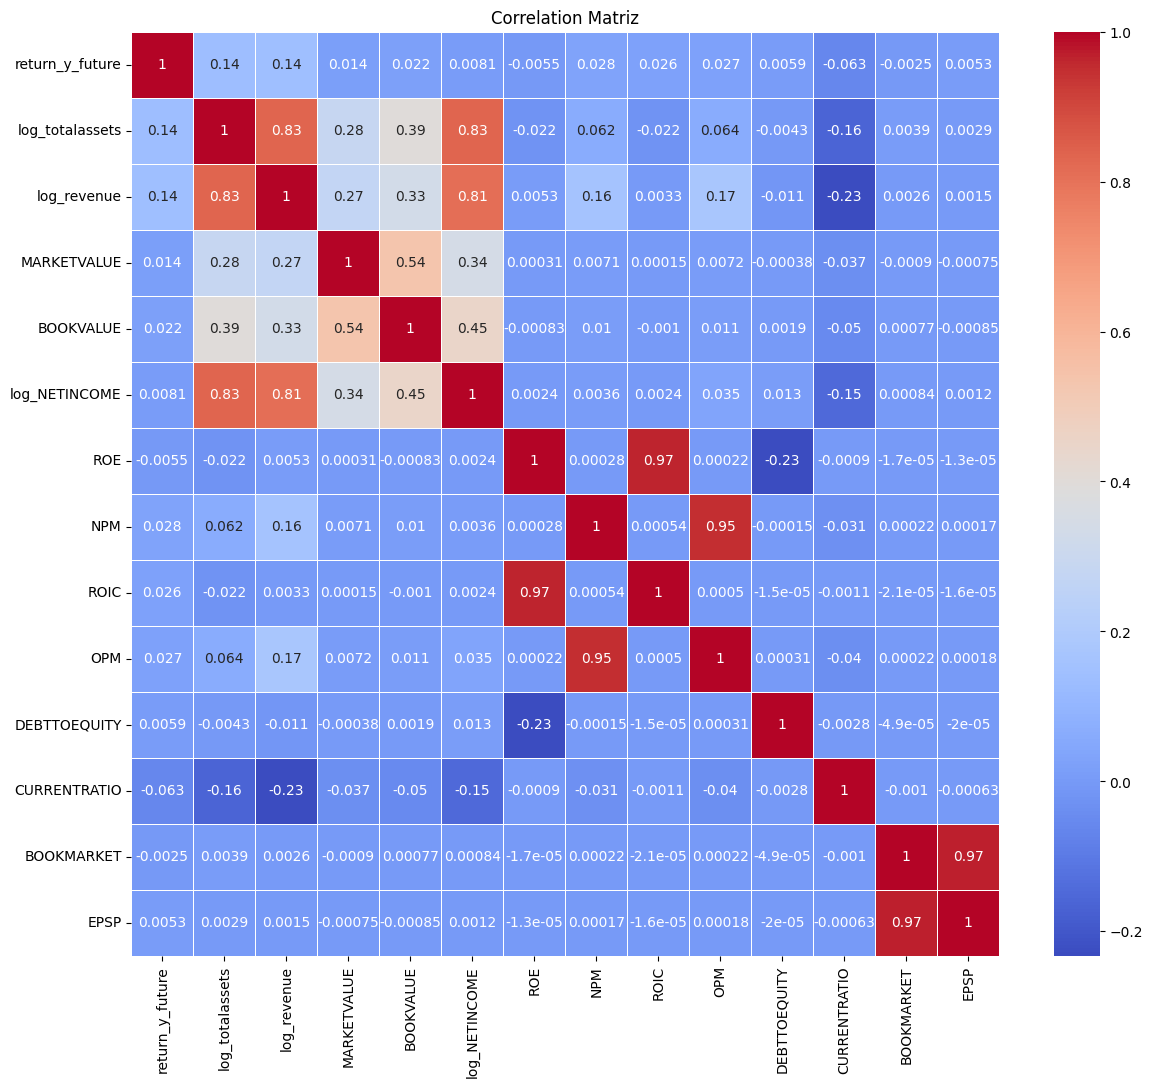

In [97]:
# Crear la matriz de correlación con seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matriz')


En una matriz de correlación, cuanto más cercana es la correlación a 1 o -1, más fuerte es la **relación lineal** (ojo, es relación lineal, puede que una x variable no presente una gran relación lineal con cierta variable, pero puede representar otro tipo de relación) entre dos variables. Una correlación cercana a 1 indica una relación positiva fuerte, mientras que una correlación cercana a -1 indica una relación negativa fuerte. Teniendo esto en cuenta, podemos analizar qué variables tienen la relación más significativa con los rendimientos anuales (return_y_future).

## Variables con mayor correlación positiva con los rendimientos futuros:
- log_revenue (0.14) y log_totalassets (0.14): Las variables con la correlación más fuerte y positiva con los rendimientos futuros son el logaritmo de los ingresos y de los activos totales, ambas con una correlación de 0.14. Esto sugiere que las empresas con mayores ingresos y activos tienden, en general, a tener mejores rendimientos anuales en el mercado. Sin embargo, el valor de correlación indica que esta relación es débil. Estas variables pueden indicar que las empresas más grandes y con mayores ingresos logran mejores resultados en el mercado, aunque no de manera significativa.

- NPM y OPM (0.03): Tanto el Margen de Beneficio Neto (NPM) como el Margen de Beneficio Operativo (OPM) tienen una correlación baja pero positiva con los rendimientos anuales. Esto sugiere que, aunque no son los principales determinantes del rendimiento futuro, las empresas que tienen márgenes de ganancia más altos tienden a tener un rendimiento levemente mejor en el mercado.

## Variables con correlación negativa con los rendimientos futuros:
- CURRENTRATIO (-0.06): El Current Ratio, que mide la capacidad de una empresa para pagar sus pasivos a corto plazo, muestra una correlación negativa con los rendimientos futuros. Esto puede indicar que las empresas con mayor liquidez no necesariamente generan mayores rendimientos en el mercado, lo que podría sugerir que estas empresas están acumulando activos a corto plazo sin generar suficiente valor adicional para sus accionistas.

## Variables con baja o nula correlación:
- ROE (-0.01): A pesar de que el ROE es comúnmente utilizado para medir la rentabilidad de una empresa, su correlación con los rendimientos futuros es extremadamente baja. Esto sugiere que el retorno sobre el patrimonio no está necesariamente vinculado al desempeño de las acciones en este análisis, posiblemente debido a que el ROE puede estar afectado por factores como la estructura de capital y no reflejar directamente el valor en el mercado de acciones.

- DEBTTOEQUITY (0.01): La relación deuda-capital no parece tener una correlación significativa con los rendimientos futuros, lo que indica que las empresas con altos niveles de endeudamiento no muestran un patrón claro en su desempeño de mercado a largo plazo en la industria manufacturera.

- MARKETVALUE (0.01): Aunque la valoración de mercado suele ser un indicador clave, en este caso tiene una correlación muy baja con los rendimientos futuros, lo que sugiere que no es un factor decisivo en este análisis.

- log_NETINCOME (0.01): El logaritmo del ingreso neto también muestra una correlación casi nula con los rendimientos anuales, lo que indica que el tamaño de los ingresos netos de una empresa no parece estar fuertemente relacionado con su rendimiento en el mercado de valores.


Las variables que tienen la relación más significativa, aunque todavía débil, con los rendimientos anuales son log_revenue y log_totalassets, ambas con una correlación de 0.14. Las métricas tradicionales como el ROE, Current Ratio y Book-to-Market ratio no parecen ser buenos predictores del rendimiento de las acciones en la industria manufacturera, al menos en este análisis. En general, la falta de correlaciones fuertes sugiere que los inversores podrían estar considerando otros factores no reflejados en estas métricas financieras tradicionales cuando se trata de evaluar el rendimiento futuro de las acciones.

#### 1.4.3 Modelo de regresión
Para cada ratio financiero, haga lo siguiente:
Hacer un histograma e interpretarlo.

Haga gráficos para visualizar la posible relación que podría tener cada factor con los rendimientos trimestrales (la variable dependiente).

Diseñe y ejecute una primera versión de un modelo de regresión múltiple para examinar si los índices seleccionados pueden explicar/predecir futuros rendimientos anuales de las acciones.

Debe comprobar posibles problemas de multicolinealidad. Explicar brevemente qué es la multicolinealidad, ejecutar e interpretar la prueba correspondiente.

Interpreta tu modelo

Interpreta con tus propias palabras los resultados de cada coeficiente (beta y su significancia estadística)

Interpretar el R cuadrado del modelo.

Escribe una conclusión de tus resultados.



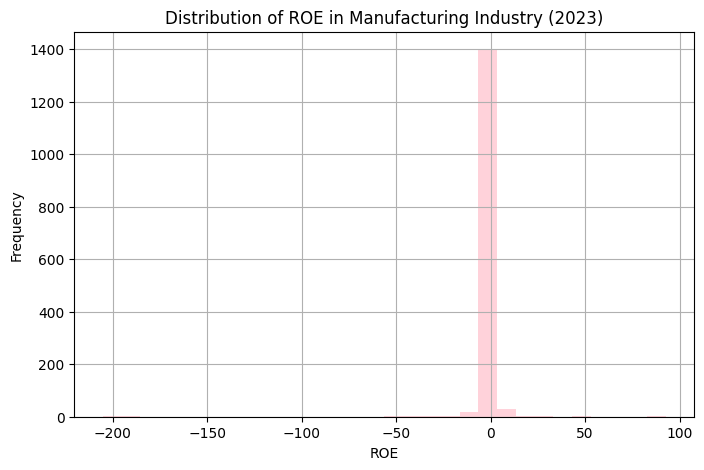

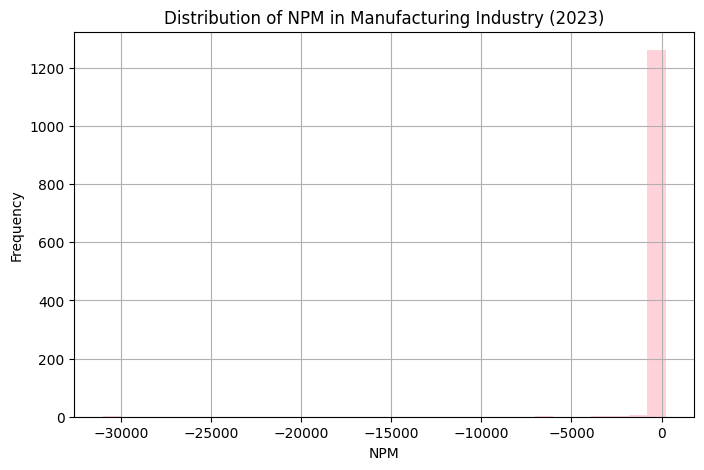

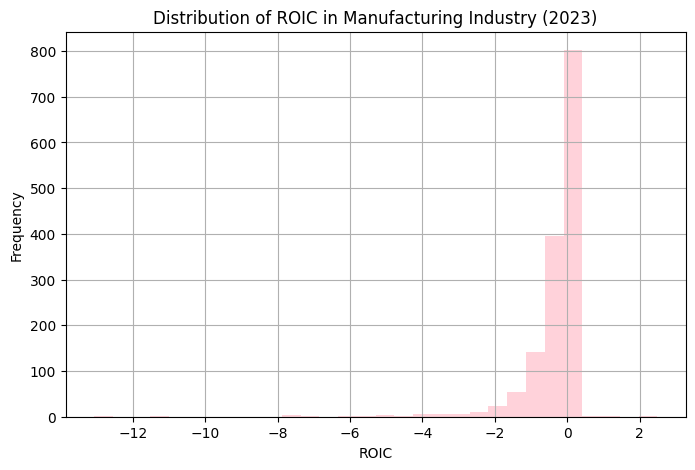

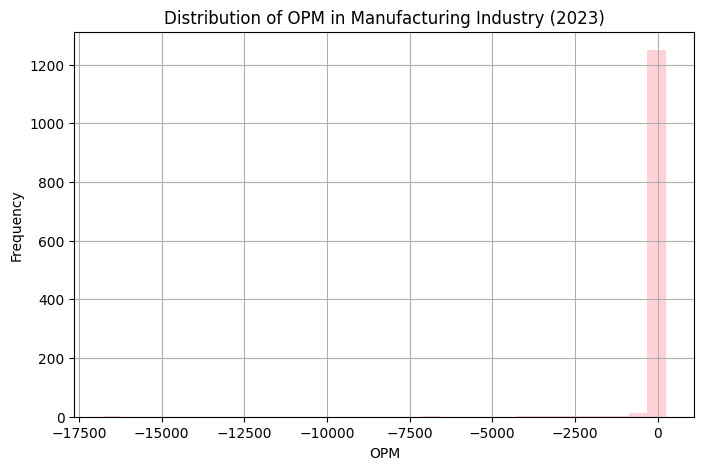

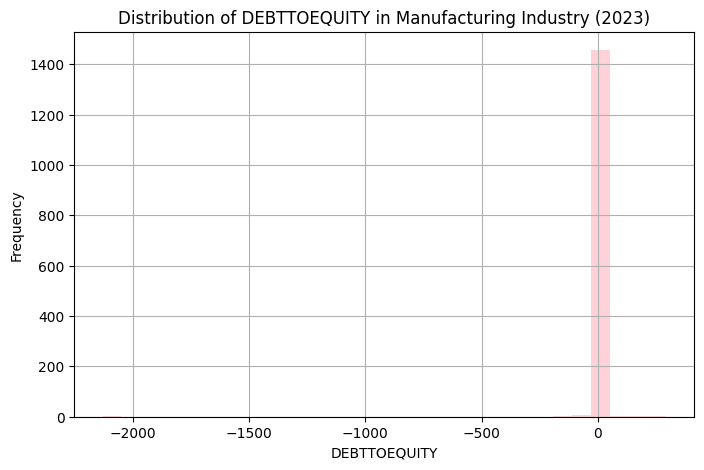

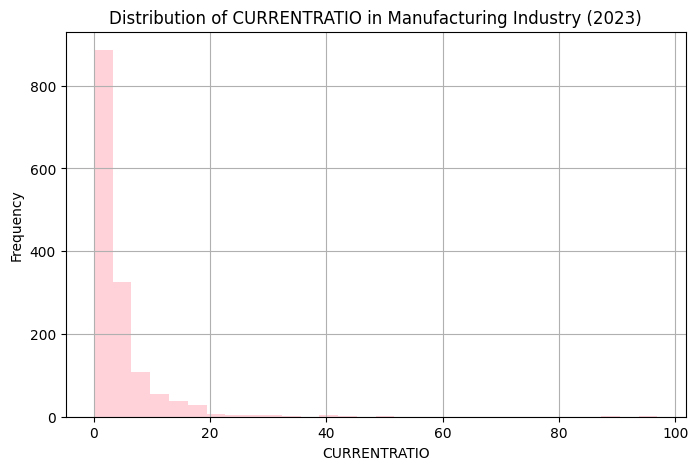

In [98]:
finantial_ratios = ['ROE', 'NPM', 'ROIC', 'OPM', 'DEBTTOEQUITY', 'CURRENTRATIO']

for ratio in finantial_ratios:
  plt.figure(figsize=(8, 5))
  # Reemplazar valores infinitos con nan
  valid_data = man_ind[ratio].replace([np.inf, -np.inf], np.nan)
  plt.hist(valid_data, bins=30, color='pink', alpha=0.7)
  plt.xlabel(ratio)
  plt.ylabel('Frequency')
  plt.title(f'Distribution of {ratio} in Manufacturing Industry (2023)')
  plt.grid(True)
  plt.show()

**Return on Equity**

La distribución del ROE muestra que la mayoría de las empresas en la industria manufacturera tienen un ROE cercano a 0. Esto indica que muchas empresas no están generando retornos significativos sobre su patrimonio, lo que puede sugerir que están teniendo dificultades para generar beneficios en relación con los fondos de los accionistas. Sin embargo, hay algunas empresas con ROEs extremos, tanto negativos como positivos, lo que sugiere que algunas están operando con pérdidas significativas, mientras que otras logran altos retornos.

**Net Profit Margin (NPM)**

El histograma del NPM presenta una gran concentración de valores negativos, con muchas empresas alcanzando márgenes de beneficio neto extremadamente bajos, incluso hasta -35,000%. Este sesgo hacia la izquierda indica que una gran parte de las empresas manufactureras están operando con pérdidas considerables, lo que refleja posibles problemas de eficiencia o altos costos operativos.

**Return on Invested Capital (ROIC)**

La distribución del ROIC está muy sesgada hacia el rango de valores negativos y cercanos a 0. Muchas empresas tienen un ROIC entre 0 y -2, lo que indica que no están generando los rendimientos esperados en relación con el capital invertido. Esta falta de eficiencia en el uso del capital sugiere que no se están optimizando los recursos para maximizar los beneficios.

**Operating Profit Margin (OPM)**

El OPM también muestra una distribución similar al NPM, con la mayoría de los valores en la parte negativa del histograma. Las empresas que tienen un OPM negativo están teniendo dificultades para convertir sus ingresos operativos en ganancias, lo que indica que sus operaciones básicas no son rentables. Un margen operativo negativo suele ser indicativo de altos costos operativos o baja demanda de productos o servicios.

**Debt to Equity (DEBTTOEQUITY)**

La distribución del ratio Debt to Equity muestra que la mayoría de las empresas tienen un nivel de endeudamiento en relación con el capital propio muy bajo, lo que indica un bajo endeudamiento financiero. Esto sugiere que muchas empresas en la industria manufacturera están financiando sus operaciones con capital propio en lugar de con deuda, lo que puede ser una señal de que las empresas prefieren no asumir altos riesgos financieros. Sin embargo, hay algunas empresas con valores de DEBTTOEQUITY extremadamente negativos, lo que sugiere que estas empresas tienen un alto nivel de deuda en comparación con su valor en libros, posiblemente debido a dificultades financieras o una alta dependencia del endeudamiento para financiar sus operaciones.

**Current Ratio (CURRENTRATIO)**

La distribución del Current Ratio en la industria manufacturera para el 2023 muestra que la mayoría de las empresas tienen un Current Ratio muy bajo, concentrándose en valores cercanos a 0. Esto indica que una gran cantidad de empresas tienen dificultades para cubrir sus obligaciones a corto plazo con sus activos corrientes. Este resultado podría reflejar una falta de liquidez en muchas empresas, lo que sugiere que no cuentan con suficientes activos disponibles para cubrir sus deudas a corto plazo. Sin embargo, hay algunas empresas con Current Ratios mucho más altos, que alcanzan hasta 100. Estos valores extremos indican que algunas compañías tienen una gran cantidad de activos líquidos en comparación con sus pasivos corrientes, lo que les da una amplia capacidad para cumplir con sus obligaciones a corto plazo.

En general, las empresas pelean por tener retornos positivos con sus operaciones, capital y capital invertido, por lo que puede indicar una época económica difícil.

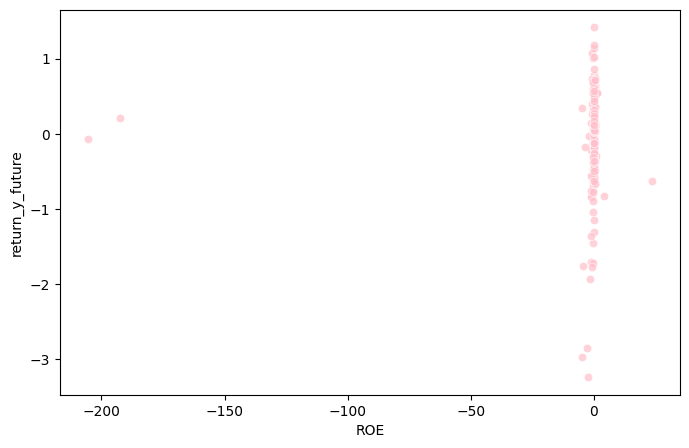

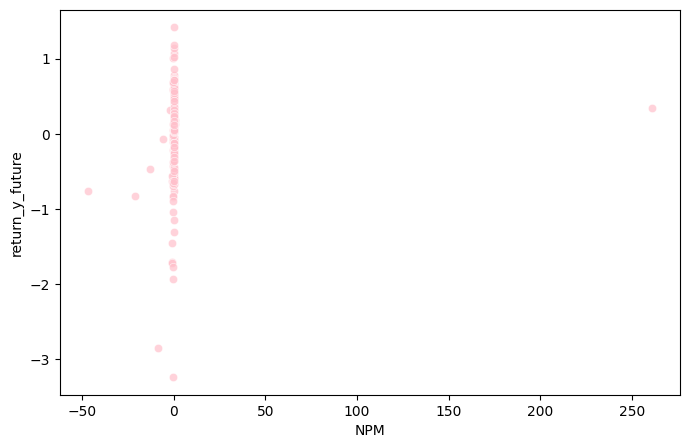

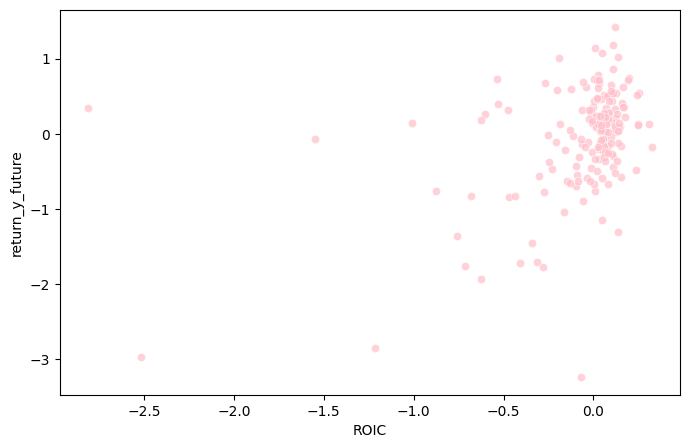

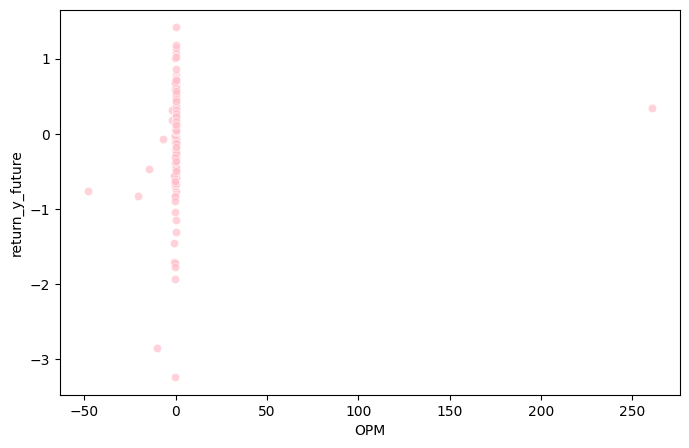

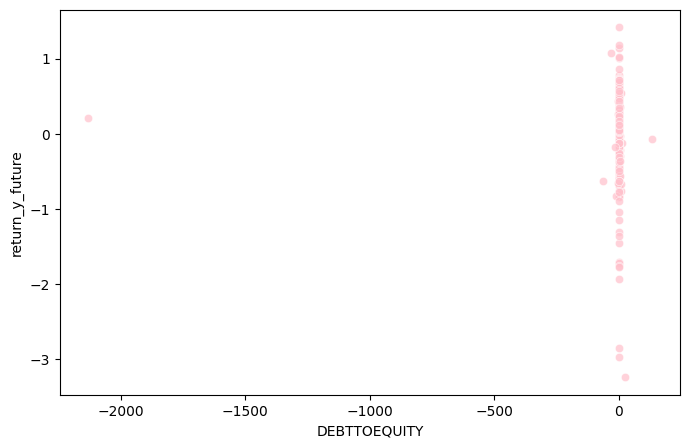

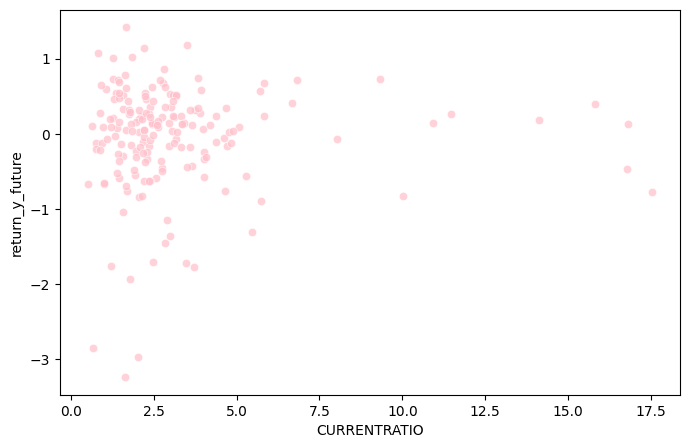

In [99]:
# Gráficas de relación: Ratios financiertos con rendimiento y futuro rendimiento
for ratio in finantial_ratios:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=ratio, y='return_y_future', data=man_ind, color='pink', alpha=0.7)
    plt.xlabel(ratio)
    plt.ylabel
    plt.show()


In [100]:
# CASO CON ÁLGEBRA MATRICIAL

# Filtrar los datos de la industria manufacturera y el mes fiscal 12
filtered_data_matrix = data[(data['industria'] == 'Industrias manufactureras') &
                             (data['fiscalmonth'] == 12)].copy()

# Seleccionar las variables independientes y dependiente
X_matrix = filtered_data_matrix[['OPM', 'ROIC', 'CURRENTRATIO', 'DEBTTOEQUITY', 'EPSP', 'BOOKMARKET']].copy()
y_matrix = filtered_data_matrix['return_y_future'].copy()

# Reemplazar valores infinitos con NaNs
X_matrix.replace([np.inf, -np.inf], np.nan, inplace=True)

# Imputar valores faltantes en las variables independientes con interpolación para que se pueda calcular el modelo
X_matrix.interpolate(inplace=True)

# Imputar valores faltantes en 'y' para que se pueda calcular el modelo
y_matrix.fillna(y_matrix.mean(), inplace=True)

# Convertir a numpy arrays
X_matrix = np.array(X_matrix)
y_matrix = np.array(y_matrix)

# Añadir la constante (columna de unos)
X_with_intercept = np.column_stack([np.ones(X_matrix.shape[0]), X_matrix])

# Verificar la singularidad de la matriz X^T X
if np.linalg.matrix_rank(X_with_intercept.T @ X_with_intercept) < X_with_intercept.shape[1]:
    print("La matriz X^T X es singular. Usando una pseudo-inversa.")
    # Usar pseudo-inversa para evitar problemas de singularidad
    beta = np.linalg.pinv(X_with_intercept.T @ X_with_intercept) @ (X_with_intercept.T @ y_matrix)
else:
    # Calcular los coeficientes beta
    beta = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ (X_with_intercept.T @ y_matrix)

# Predicciones
y_pred_matrix = X_with_intercept @ beta

# Calcular el Mean Squared Error (MSE)
n_matrix = len(y_matrix)
p_matrix = X_with_intercept.shape[1] - 1
mse_matrix = np.sum((y_matrix - y_pred_matrix) ** 2) / (n_matrix - p_matrix - 1)

# Calcular la varianza de los coeficientes
var_beta_matrix = mse_matrix * np.linalg.inv(X_with_intercept.T @ X_with_intercept)

# Errores estándar de los coeficientes
std_err_matrix = np.sqrt(np.diag(var_beta_matrix))

# Calcular R²
ss_total_matrix = np.sum((y_matrix - np.mean(y_matrix)) ** 2)
ss_residual_matrix = np.sum((y_matrix - y_pred_matrix) ** 2)
r_squared_matrix = 1 - (ss_residual_matrix / ss_total_matrix)

# Calcular R² ajustado
r_squared_adjusted_matrix = 1 - ((1 - r_squared_matrix) * (n_matrix - 1) / (n_matrix - p_matrix - 1))

# Calcular la matriz hat
hat_matrix_matrix = X_with_intercept @ np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T

# Identificar leverage points
leverage_matrix = np.diag(hat_matrix_matrix)
leverage_threshold_matrix = 2 * (p_matrix + 1) / n_matrix
high_leverage_points_matrix = np.where(leverage_matrix > leverage_threshold_matrix)[0]

# Resultados
print("Coeficientes calculados (beta):")
print(beta)
print("\nErrores estándar de los coeficientes:")
print(std_err_matrix)
print(f"\nR²: {r_squared_matrix:.6f}")
print(f"R² ajustado: {r_squared_adjusted_matrix:.6f}")
print("\nPuntos críticos:")
print(f"Umbral de leverage: {leverage_threshold_matrix}")
print(f"Observaciones con alto leverage: {high_leverage_points_matrix}")

Coeficientes calculados (beta):
[-1.19480446e-02  6.05330948e-05 -3.54670428e-08 -9.47952920e-03
  2.63514482e-05 -6.78195068e-08 -2.48084829e-08]

Errores estándar de los coeficientes:
[4.83680193e-03 1.27174530e-05 9.33738872e-06 6.61232914e-04
 1.86899745e-05 4.05941823e-06 1.27141526e-07]

R²: 0.009670
R² ajustado: 0.009426

Puntos críticos:
Umbral de leverage: 0.0005745003898395502
Observaciones con alto leverage: [  103   161   216   218   273   274   358   382   528   529   542   550
   761   797   798   799   813   894   945   981   987   988  1083  1084
  1085  1093  1094  1095  1096  1097  1098  1154  1248  1258  1327  1562
  1596  1597  1645  1649  1664  1804  1841  1843  1866  1886  1934  1982
  1983  2085  2201  2202  2295  2296  2297  2298  2299  2300  2301  2302
  2328  2329  2330  2499  2565  2692  2694  2749  2921  2963  3146  3149
  3150  3384  3497  3551  3710  3717  3849  3850  3851  3852  3853  3854
  3855  3922  3923  3924  3925  3926  3928  4030  4160  4161  4916

In [101]:
# MODELO BASE

# Asegurarnos de aplicar los mismos filtros desde el principio
filtered_data_inicial = data[(data['industria'] == 'Industrias manufactureras') &
                            (data['fiscalmonth'] == 12)].copy()

# Seleccionar solo las variables necesarias para 'X' y 'y' a partir del conjunto filtrado inicial
X = filtered_data_inicial[['OPM', 'ROIC', 'CURRENTRATIO', 'DEBTTOEQUITY', 'EPSP', 'BOOKMARKET']].copy()
y = filtered_data_inicial['return_y_future'].copy()

# Guardar los índices originales
original_indices = X.index.copy()

# Reemplazar valores infinitos y NaNs con valores nulos en 'X'
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Añadir la constante para el modelo
X = sm.add_constant(X)

# Crear el modelo OLS, eliminando observaciones con valores faltantes
model = sm.OLS(y, X, missing='drop').fit()

# Imprimir el resumen del modelo base
print("Resumen del modelo base:")
print(model.summary())

Resumen del modelo base:
                            OLS Regression Results                            
Dep. Variable:        return_y_future   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     127.0
Date:                Wed, 09 Oct 2024   Prob (F-statistic):          2.71e-158
Time:                        22:59:30   Log-Likelihood:                -18025.
No. Observations:               19910   AIC:                         3.606e+04
Df Residuals:                   19903   BIC:                         3.612e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0296

In [102]:
# Obtener la matriz de influencia
influence = model.get_influence()

# Obtener los valores diagonales de la matriz hat (los leverage points)
hat_matrix_diag = influence.hat_matrix_diag

# Definir un umbral común para identificar leverage points
k = X.shape[1] - 1      # número de predictores
n = X.shape[0]          # número de observaciones
leverage_threshold = 2 * (k + 1) / n

# Identificar leverage points altos
high_leverage_points = np.where(hat_matrix_diag > leverage_threshold)[0]

# Calcular el porcentaje de leverage points altos sobre el total de observaciones
percent_leverage_points = len(high_leverage_points) / n

print(f"Porcentaje de leverage points altos: {percent_leverage_points:.4f}")

# Identificar qué filas fueron eliminadas en 'X' debido a los valores faltantes
dropped_indices = original_indices.difference(X.index)

# Reinsertar las filas eliminadas como NaN en 'X' y 'y' para que cuadren con los índices originales
X_full = pd.DataFrame(index=original_indices, columns=X.columns)
X_full.update(X)  # Actualizar con los valores no eliminados
X_full.loc[dropped_indices] = np.nan  # Reinsertar las filas eliminadas con NaN

y_full = pd.Series(index=original_indices)
y_full.update(y)
y_full.loc[dropped_indices] = np.nan

# Winsorizar cada columna de las variables independientes de acuerdo al porcentaje de leverage points altos
X_winsorized = X_full.copy()

for col in X_winsorized.columns:
    if col != 'const':  # No aplicar winsorización a la constante
        # Ordenar los valores y obtener los percentiles basados en el porcentaje de leverage points altos
        lower_limit = np.percentile(X_winsorized[col], percent_leverage_points * 100 / 2)
        upper_limit = np.percentile(X_winsorized[col], 100 - (percent_leverage_points * 100 / 2))

        # Aplicar winsorización solo a los valores fuera de esos límites
        X_winsorized[col] = np.clip(X_winsorized[col], lower_limit, upper_limit)

# Asegurarnos de que no se eliminan filas y las columnas sean numéricas
X_winsorized = X_winsorized.apply(pd.to_numeric, errors='coerce')

# Aplicar interpolación solo a las columnas numéricas para rellenar valores faltantes si es necesario
X_winsorized.interpolate(inplace=True)

# Crear el modelo OLS con los datos winsorizados
model_winsorized = sm.OLS(y_full, X_winsorized, missing='drop').fit()

# Imprimir el resumen del modelo winsorizado
print("\nResumen del modelo winsorizado:")
print(model_winsorized.summary())


Porcentaje de leverage points altos: 0.0242

Resumen del modelo winsorizado:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     289.8
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:59:31   Log-Likelihood:                -20650.
No. Observations:               21567   AIC:                         4.131e+04
Df Residuals:                   21560   BIC:                         4.137e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

**Leverages**

Los leverage points son observaciones que, debido a su posición en el espacio de las variables independientes (VI), ejercen una mayor influencia sobre los valores predichos por el modelo. Estos se identifican a través de la matriz hat, cuyos valores diagonales indican el leverage de cada observación. Un valor de leverage cercano a 1 indica una observación con gran influencia, mientras que valores cercanos a 0 indican bajo leverage.

En mi caso, utilicé el criterio común de 2 * ((k+1)/n) como umbral para identificar las observaciones con alto leverage. Esto me permitió encontrar qué observaciones están ejerciendo una mayor influencia en el ajuste del modelo. En este análisis, el porcentaje de leverage points altos fue del 2.42%, lo que significa que una pequeña porción de las observaciones está ejerciendo más influencia sobre los coeficientes estimados del modelo.

Las observaciones con valores extremos en las VI tienden a ser leverage points, ya que están alejadas del "centro" de los datos, lo que les otorga más peso en la determinación de la línea de regresión. Si no se gestionan adecuadamente, pueden distorsionar el ajuste del modelo.

**Winsorización**

La winsorización es una técnica utilizada para reducir el impacto de los outliers, aplanando los valores extremos dentro de un rango predefinido en lugar de eliminarlos. Esto es útil cuando los valores extremos podrían estar distorsionando el modelo, pero no se desea eliminarlos completamente para preservar el mayor número posible de observaciones.

En mi caso, en lugar de utilizar el IQR (rango intercuartílico) para winsorizar los datos, decidí aplicar un enfoque basado en el porcentaje de leverage points altos. Calculé los percentiles basados en este porcentaje, y luego aplané los valores extremos de las variables independientes dentro de esos límites. Este enfoque permitió reducir la influencia de los outliers en el modelo, manteniendo las observaciones y mejorando la estabilidad de los coeficientes estimados.

**Impacto en el modelo**

El modelo después de aplicar winsorización mostró un R² de 0.075, lo que indica una mejora con respecto al modelo base, aunque el ajuste sigue siendo bajo. Esto sugiere que la winsorización ayudó a estabilizar el modelo frente a outliers y leverage points, pero aún hay margen para mejorar el ajuste global del modelo. Además, variables como ROIC y BOOKMARKET muestran una fuerte influencia positiva en los resultados del modelo, mientras que variables como CURRENTRATIO tienen un impacto negativo significativo.

In [103]:
# Obtener la influencia del modelo winsorizado
influence_winsorized = model_winsorized.get_influence()

# Obtener los residuos studentizados
studentized_residuals_winsorized = influence_winsorized.resid_studentized_external

# Obtener los valores de Cook's Distance
cooks_distance_winsorized, _ = influence_winsorized.cooks_distance

# Umbral para Cook's Distance
cooks_threshold_winsorized = 4 / len(X_winsorized)

# Identificar outliers con residuos studentizados fuera del rango [-3, 3]
outliers_residuals = np.where(np.abs(studentized_residuals_winsorized) > 3)[0]

# Identificar outliers con Cook's Distance por encima del umbral
outliers_cooks = np.where(cooks_distance_winsorized > cooks_threshold_winsorized)[0]

# Combinar los índices de outliers (residuals + Cook's Distance)
outliers_combined = np.union1d(outliers_residuals, outliers_cooks)

# Mostrar los resultados
print(f"Outliers por residuos studentizados: {len(outliers_residuals)}")
print(f"Outliers por Cook's Distance: {len(outliers_cooks)}")
print(f"Outliers combinados (residuals + Cook's Distance): {len(outliers_combined)}")


Outliers por residuos studentizados: 374
Outliers por Cook's Distance: 1720
Outliers combinados (residuals + Cook's Distance): 1754


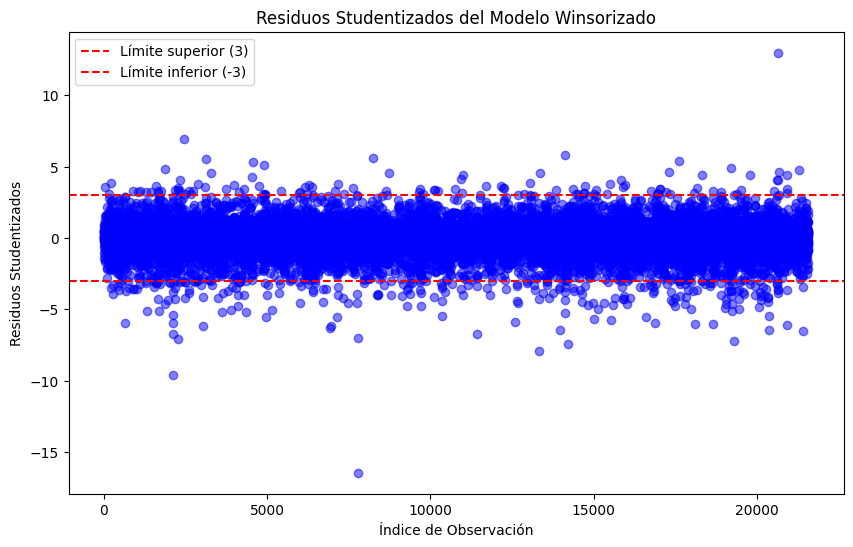

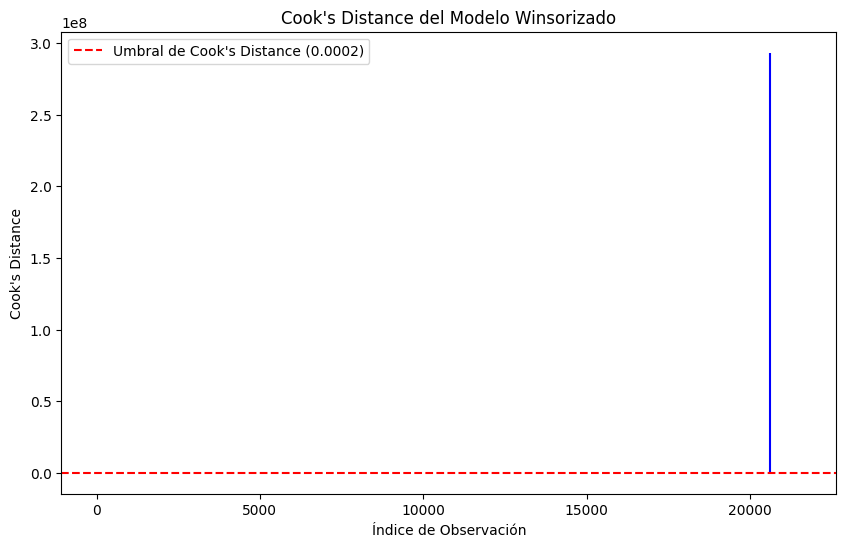

In [104]:
# Gráfica de los residuos studentizados
plt.figure(figsize=(10, 6))
plt.scatter(range(len(studentized_residuals_winsorized)), studentized_residuals_winsorized, alpha=0.5, color='blue')
plt.axhline(y=3, color='red', linestyle='--', label='Límite superior (3)')
plt.axhline(y=-3, color='red', linestyle='--', label='Límite inferior (-3)')
plt.title('Residuos Studentizados del Modelo Winsorizado')
plt.xlabel('Índice de Observación')
plt.ylabel('Residuos Studentizados')
plt.legend()
plt.show()

# Gráfica de Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(range(len(cooks_distance_winsorized)), cooks_distance_winsorized, markerfmt=" ", basefmt=" ", linefmt='b-')
plt.axhline(y=cooks_threshold_winsorized, color='red', linestyle='--', label=f'Umbral de Cook\'s Distance ({cooks_threshold_winsorized:.4f})')
plt.title('Cook\'s Distance del Modelo Winsorizado')
plt.xlabel('Índice de Observación')
plt.ylabel('Cook\'s Distance')
plt.legend()
plt.show()


In [105]:
# Obtener los índices reales de outliers en el DataFrame original
outliers_combined_real_indices = X_winsorized.iloc[outliers_combined].index

# Dropear los outliers combinados de X_winsorized y y_full usando los índices reales
X_cleaned = X_winsorized.drop(index=outliers_combined_real_indices)
y_cleaned = y_full.drop(index=outliers_combined_real_indices)

# Crear un nuevo modelo OLS con los datos limpiados
model_cleaned = sm.OLS(y_cleaned, X_cleaned, missing = 'drop').fit()

# Imprimir el resumen del nuevo modelo
print("\nResumen del modelo después de eliminar los outliers:")
print(model_cleaned.summary())



Resumen del modelo después de eliminar los outliers:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     272.6
Date:                Wed, 09 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:02:08   Log-Likelihood:                -19181.
No. Observations:               20002   AIC:                         3.838e+04
Df Residuals:                   19995   BIC:                         3.843e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

**Identificación de outliers utilizando residuals studentizados**

Los residuals studentizados son residuos escalados según su varianza, lo que significa que cada residuo es ajustado por su error estándar. Esto permite identificar outliers de manera más precisa, ya que un residuo studentizado mayor a 3 o menor a -3 generalmente indica un outlier. Estos valores extremos representan observaciones que el modelo no predice bien en comparación con el resto de los datos.

En mi gráfica de residuos studentizados, se puede observar una gran cantidad de puntos que caen fuera del rango aceptado [-3, 3]. Estos outliers reflejan observaciones que no siguen el mismo patrón que el resto de los datos, lo que podría estar afectando el ajuste del modelo de manera negativa.

**Identificación de outliers utilizando Cook’s Distance**

Cook’s Distance mide la influencia de una observación individual sobre el ajuste de la regresión. Las observaciones con un valor de Cook’s Distance alto indican que si se eliminara esa observación, el modelo cambiaría significativamente.

Utilicé el criterio de 4/n (n es número de observaciones) para identificar el límite para que un punto se convierta en outlier. Observaciones con valores altos de Cook’s Distance son aquellas que están afectando de manera importante los coeficientes del modelo y pueden ser consideradas para una revisión más detallada o eliminación.

Al tener tantos outliers según las gráficas de arriba, decidí mejor dropearlos (borrarlos) todos, para que no sesgue mi modelo.

**Comparación del modelo original y el mejorado**

En el modelo base, el  R^2 ajustado fue de 0.037, lo que indica que el modelo explicaba solo el 3.7% de la variabilidad en los rendimientos futuros. Este valor sugiere que, aunque el modelo tenía significancia estadística, una gran parte de la variabilidad en los datos no estaba siendo explicada correctamente.

Después de aplicar winsorización y eliminar los outliers identificados a través de los residuos studentizados y Cook's Distance, el  R^2 ajustado del modelo mejorado subió a 0.076. Aunque el incremento en el  R^2 ajustado no es muy grande, sí representa una mejora notable, ya que el modelo ajustado es capaz de explicar un 7.6% de la variabilidad en los rendimientos futuros, el doble de lo que explicaba el modelo base.

Además, varias variables como ROIC y BOOKMARKET se mantuvieron estadísticamente significativas en el modelo mejorado, mientras que otras como DEBTTOEQUITY comenzaron a mostrar mayor relevancia, lo que refuerza la idea de que los outliers en el modelo original estaban distorsionando la relación real entre las variables. Al eliminar estos outliers, los coeficientes del modelo se estabilizan y reflejan de manera más precisa las relaciones entre las variables.

En resumen, el modelo mejorado es claramente más robusto y confiable que el modelo base. No solo presenta un mayor R^2 ajustado, sino que también tiene coeficientes más consistentes y estables. La aplicación de winsorización y la eliminación de outliers han reducido el sesgo en el modelo, permitiendo que capture de manera más precisa las relaciones entre las variables y los rendimientos futuros.

## Interpretación
### Coeficientes beta:
Los coeficientes beta representan la magnitud y cambio de la variable dependiente (DV), que en este caso es "return_y_future" (debido a que queremos predecir los retornos futuros) por cambio en la variable independiente (IV), que en este caso es un conjunto de variables: "ROIC", "log_totalassets", "log_revenue" y "OPM".
### P-value e Intervalo de Confianza
El intervalo de confianza estima el 95% de la probabilidad de que el coeficiente beta esté dentro del modelo de regresión, es decir, la probabilidad de que exista un 95% de confianza de que el intervalo contenga el verdadero valor de un parámetro.
Si el intervalo de confianza no incluye el 0, se sugiere que el coeficiente beta es estadísticamente significativo, pues la variable independiente tiene un efecto sobre la dependiente. Por otro lado, si el intervalo de confianza incluye el 0, no se puede descartar la probabilidad que el coeficiente beta sea 0, es decir, que la IV no tiene efecto sobre la DV.

Esto se relaciona con la hipótesis nula (H0) que dice que un coeficiente beta es 0, que indica que no hay relación lineal entre la IV y la DV, por lo que, al no incluir el 0 en el intervalo de confianza, se puede descartar la hipótesis nula, mientras que, cuando el intervalo de confianza incluye el 0, quiere decir que no hay evidencia suficiente para rechazar la hipótesis nula (no se puede afirmar que existe una relación significativa entre las variables).

El p-value dice qué tan probable es que el coeficiente beta ocurra por mera casualidad, por lo que se usa un umbral de significancia de 0.05 para ver si se considera significativo y que se pueda rechazar la hipótesis nula. Si el p-value es menor a 0.05, el intervalo de confianza del 95% no va a incluir al 0, indicando que el beta es significativamente diferente de 0 y que por ende, tiene efecto en la variable y (que queremos predecir).

### Coeficientes beta obtenidos y su análisis
- ROIC
    - Coeficiente Beta: 0.3695
    - P-value: 0.000
    - Intervalo de Confianza (95%): [0.344, 0.395]
    - Interpretación: Por cada unidad de aumento en el ROIC, el retorno futuro aumenta en 0.3695 unidades. El p-value es extremadamente bajo, lo que indica que el coeficiente es altamente significativo. El intervalo de confianza no incluye el 0, lo que confirma que existe una relación positiva y significativa entre ROIC y los rendimientos futuros. Esto sugiere que las empresas que son más eficientes en el uso de su capital tienden a generar mayores rendimientos futuros.
- CURRENTRATIO
    - Coeficiente Beta: -0.0121
    - P-value: 0.000
    - Interpretación: Por cada unidad de aumento en el ratio de liquidez corriente (Current Ratio), los rendimientos futuros disminuyen en 0.0121 unidades. El p-value es bajo, lo que indica que el coeficiente es significativo. El intervalo de confianza no incluye el 0, lo que refuerza que hay una relación negativa y significativa. Esto sugiere que, en este contexto, un alto Current Ratio puede estar asociado con menores rendimientos futuros, posiblemente porque las empresas con un exceso de liquidez no están utilizando de manera eficiente sus recursos.
- DEBTTOEQUITY
    - Coeficiente Beta: 0.0026
    - P-value: 0.043
    - Interpretación: Por cada unidad de aumento en el ratio de deuda a patrimonio (Debt to Equity), los rendimientos futuros aumentan en 0.0026 unidades. Aunque el coeficiente es pequeño, el p-value indica que la relación es estadísticamente significativa. El intervalo de confianza incluye valores cercanos a 0, lo que sugiere que el impacto es leve. Sin embargo, esta relación puede indicar que las empresas con más deuda en relación con su patrimonio pueden generar mayores rendimientos, aunque con un mayor riesgo financiero.
- OPM
    - Coeficiente Beta: 0.0021
    - P-value: 0.000
    - Intervalo de Confianza (95%): [0.057, 0.151]
    - Interpretación: Por cada unidad de aumento en el margen operativo (Operating Profit Margin), el retorno futuro aumenta en 0.0021 unidades. El p-value es muy bajo, lo que confirma la significancia estadística, aunque el coeficiente es pequeño. Esto sugiere que la eficiencia operativa tiene una relación positiva, pero moderada, con los rendimientos futuros.

- EPSP
    - Coeficiente Beta: 1.292e-06
    - P-value: 0.465
    - Intervalo de Confianza (95%): [-2.17e-06, 4.76e-06]
    - Interpretación: El coeficiente para EPSP es extremadamente pequeño (casi cero) y no es estadísticamente significativo, ya que el p-value es alto (0.465). Esto indica que no se encontró una relación significativa entre las ganancias por acción y los rendimientos futuros en este modelo, lo cual podría estar relacionado con otros factores que influyen en el retorno futuro.

- BOOKMARKET
    - Coeficiente Beta: 0.0656
    - P-value: 0.000
    - Intervalo de Confianza (95%): [0.046, 0.086]
    - Interpretación: Por cada unidad de aumento en el ratio de valor en libros a valor de mercado (BOOKMARKET), el retorno futuro aumenta en 0.0656 unidades. El p-value es extremadamente bajo, lo que indica significancia estadística, y el intervalo de confianza no incluye el 0. Esto sugiere que las empresas con un alto valor en libros en relación con su valor de mercado tienden a generar mayores rendimientos futuros.

In [106]:
# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_cleaned.columns
vif_data["VIF"] = [variance_inflation_factor(X_cleaned.values, i) for i in range(X_cleaned.shape[1])]

# Mostrar los resultados de VIF
print(vif_data)


       Variable       VIF
0         const  3.017633
1           OPM  1.465574
2          ROIC  1.379242
3  CURRENTRATIO  1.102649
4  DEBTTOEQUITY  1.025693
5          EPSP  1.000844
6    BOOKMARKET  1.008279


**Multicolienalidad**

La multicolinealidad ocurre cuando dos o más variables independientes en un modelo de regresión están altamente correlacionadas entre sí. Esto significa que las variables no aportan información completamente nueva al modelo, ya que están midiendo algo muy similar. El problema principal con la multicolinealidad es que puede inflar los errores estándar de los coeficientes estimados, lo que a su vez puede hacer que los p-values sean más altos. Cuando esto ocurre, podría parecer que una variable no tiene una influencia significativa en la variable dependiente, aunque en realidad sí la tenga.

**Prueba VIF**

Para detectar multicolinealidad, se utiliza el Factor de Inflación de la Varianza (VIF), que mide cuánto aumenta la varianza de un coeficiente de regresión debido a la colinealidad con otras variables. Un VIF alto (generalmente por encima de 10) indica un problema de multicolinealidad, mientras que valores más bajos sugieren que las variables están relativamente independientes entre sí.

**¿Multicolienalidad en mis datos?**

En mis datos, los valores de VIF están todos muy por debajo de 10, lo que indica que no hay un problema serio de multicolinealidad. El VIF más alto es el de la constante (3.02), y el de ROIC es de 1.38, lo cual indica que hay correlación entre algunas variables, pero no lo suficientemente alta como para causar preocupación. Esto sugiere que las variables en el modelo no están aportando información redundante, y cada una contribuye de manera significativa sin causar distorsión en el modelo.


**Interpretación del Adjusted R-square del modelo**

El Adjusted R-squared ajusta el R-squared para el número de variables en el modelo y es una medida clave para entender cuánta variabilidad en la variable dependiente (return_y_future) está siendo explicada por las variables independientes (OPM, ROIC, Current Ratio, Debt to Equity, EPSP, Book to Market).

En este modelo, el Adjusted R-squared es de 0.075, lo que significa que el 7.5% de la variabilidad en los rendimientos futuros puede explicarse por las variables seleccionadas. Aunque este valor podría parecer bajo, es común en modelos financieros debido a la naturaleza compleja y volátil de los mercados, donde hay muchos factores externos que afectan los resultados. Esto indica que, aunque el modelo es útil, no captura toda la variabilidad, y hay otros factores que también influyen en los rendimientos futuros.

**Variable con mayor poder explicativo**

El ROIC (Return on Invested Capital) es la variable con mayor impacto positivo en los rendimientos futuros. El coeficiente beta de 0.3695 indica que, por cada unidad adicional de ROIC, los rendimientos futuros aumentan en 0.3695 unidades. Además, el p-value asociado a ROIC es extremadamente bajo (0.000), lo que indica que esta relación es estadísticamente significativa.

Financieramente, esto significa que las empresas que utilizan su capital invertido de manera eficiente tienden a generar mejores rendimientos futuros. Un ROIC alto es un indicador de que la empresa está maximizando el valor de sus inversiones, lo que resulta atractivo para los inversionistas. Este resultado es coherente con la teoría financiera, ya que un alto ROIC sugiere una mayor rentabilidad y eficiencia en el uso del capital.

**Interpretación de un coeficiente negativo y significativo**

En este modelo, el Current Ratio tiene un coeficiente negativo de -0.0121 y un p-value de 0.000, lo que indica que es altamente significativo. Esto significa que, por cada unidad de aumento en el Current Ratio, los rendimientos futuros disminuyen en 0.0121 unidades.

El Current Ratio mide la capacidad de una empresa para cubrir sus obligaciones a corto plazo con sus activos corrientes. Normalmente, un Current Ratio alto se percibe como algo positivo, ya que indica que la empresa puede cumplir con sus obligaciones fácilmente. Sin embargo, un Current Ratio excesivamente alto también puede significar que la empresa está acumulando demasiada liquidez y no está invirtiendo eficientemente sus recursos. Este coeficiente negativo sugiere que las empresas manufactureras con un Current Ratio elevado pueden estar sacrificando oportunidades de crecimiento e inversión, lo que a su vez puede afectar negativamente sus rendimientos futuros.

Para los inversionistas y directores de empresa, este resultado es una advertencia de que mantener un Current Ratio demasiado alto podría ser contraproducente en términos de maximización de valor. En lugar de acumular activos, la empresa debería encontrar un equilibrio entre la liquidez y la inversión en oportunidades de crecimiento.

**Conclusiones**

- ROIC (Return on Invested Capital) es la variable más importante en el modelo para explicar los rendimientos futuros. Las empresas que logran mayores retornos sobre su capital tienden a generar rendimientos más altos en el mercado, lo que subraya la importancia de utilizar eficientemente el capital invertido.

- Current Ratio tiene un impacto negativo y significativo en los rendimientos futuros, lo que indica que las empresas con una alta proporción de liquidez podrían estar siendo demasiado conservadoras y no están invirtiendo sus recursos de manera eficiente para maximizar sus rendimientos.

- No se observa un problema significativo de multicolinealidad en el modelo, lo que permite interpretar los coeficientes con confianza, sabiendo que las variables independientes aportan información única y no redundante.


# Bloque #2

## 1.1 Regresión Múltiple - Tópicos avanzados
### 1.1.1 Cálculo de variables

Para obtener el conjunto de datos históricos completo de los años fiscales anuales (mes fiscal = 12 para todos los trimestres) de su industria, debe calcular las siguientes variables:

- El tamaño de la empresa como variable categórica. Para cada año fiscal (yearf), debe etiquetar las empresas en 3 grupos iguales: pequeñas, medianas y grandes según el valor de mercado de las empresas.
- Calcule las variables ficticias (binarias) correspondientes para el tamaño de la empresa siguiendo el método de codificación ficticia (no la codificación one-hot).

In [107]:
# Filtrar los datos para mes fiscal 12 y la industria manufacturera
data_annual = data[(data['fiscalmonth'] == 12) & (data['industria'] == 'Industrias manufactureras')].copy()

# Categorizar las empresas por pequeñas, medianas y grandes según su MARKETVALUE
def firm_size_categorizer(group):
    market_values = group['MARKETVALUE'].dropna()
    tercios = market_values.quantile([1/3, 2/3])
    bins = [-float('inf'), tercios.iloc[0], tercios.iloc[1], float('inf')]
    labels = ['Pequeña', 'Mediana', 'Grande']
    
    # Aplicar pd.cut a los valores sin NaN y asignar las categorías
    group.loc[market_values.index, 'firm_size'] = pd.cut(
        market_values, bins=bins, labels=labels, include_lowest=True
    )
    
    return group

# Aplicar la función de categorización a cada grupo de empresas por año
data_annual = data_annual.groupby('year').apply(firm_size_categorizer)

# Crear variables dummy, utilizando codificación ficticia (eliminando la primera categoría)
size_dummies = pd.get_dummies(data_annual['firm_size'], prefix='size', drop_first=True)
data_annual = pd.concat([data_annual, size_dummies], axis=1)

# Seleccionar las variables relevantes para el análisis
analysis_variables = [
    'year', 'Empresa', 'MARKETVALUE', 'firm_size', 'size_Mediana', 'size_Grande', 'return_q_future',
    'OPM', 'ROIC', 'CURRENTRATIO', 'DEBTTOEQUITY', 'EPSP', 'BOOKMARKET', 'longdebt', 'totalassets'
]

data_analysis = data_annual[analysis_variables].copy()

print(data_analysis.head())

                      year                    Empresa   MARKETVALUE firm_size  \
year firm     qdate                                                             
2000 A        2000Q4  2000  Agilent Technologies, Inc  2.498606e+07    Grande   
     AAPL     2000Q3  2000                  Apple Inc  8.367953e+06    Grande   
     ABGX_old 2000Q4  2000                Abgenix Inc  5.022930e+06   Mediana   
     ABH_old  2000Q4  2000                Bowater Inc  2.824393e+06   Mediana   
     ABI_old  2000Q2  2000     Applied Biosystems Inc  1.374863e+07    Grande   

                      size_Mediana  size_Grande  return_q_future       OPM  \
year firm     qdate                                                          
2000 A        2000Q4         False         True        -0.577538  0.097744   
     AAPL     2000Q3         False         True        -0.548753  0.065389   
     ABGX_old 2000Q4          True        False        -0.913628 -1.563926   
     ABH_old  2000Q4          True        

C:\Users\marif\AppData\Local\Temp\ipykernel_26024\1913212429.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_annual = data_annual.groupby('year').apply(firm_size_categorizer)


### 1.1.2 Modelo de Regresión Múltiple
- Asegúrese de proponer medidas correctivas para aprovechar los valores (extremos) de las variables y los posibles valores atípicos.

- Ejecute un primer modelo de regresión múltiple para examinar si los ratios financieros y el tamaño de la empresa explican/predicen los rendimientos anuales futuros de las acciones (un trimestre después).

In [108]:
# Definir el mismo porcentaje de leverage points que encontré antes
percent_leverage_points = len(high_leverage_points) / n

# Aplicar winsorización a 'data_analysis'
variables_to_winsorize = ['OPM', 'ROIC', 'CURRENTRATIO', 'DEBTTOEQUITY', 'EPSP', 'BOOKMARKET']

for var in variables_to_winsorize:
    lower_limit = np.percentile(data_analysis[var].dropna(), percent_leverage_points * 100 / 2)
    upper_limit = np.percentile(data_analysis[var].dropna(), 100 - (percent_leverage_points * 100 / 2))
    data_analysis[var] = np.clip(data_analysis[var], lower_limit, upper_limit)

# Filtrar los datos para variables relevantes, incluyendo los dummies de tamaño de empresa
X_new = data_analysis[['OPM', 'ROIC', 'CURRENTRATIO', 'DEBTTOEQUITY', 'EPSP', 'BOOKMARKET', 'size_Mediana', 'size_Grande']].copy()
X_new['size_Mediana'] = X_new['size_Mediana'].astype(float)
X_new['size_Grande'] = X_new['size_Grande'].astype(float)
y_new = data_analysis['return_q_future'].copy()

# Añadir la constante al modelo
X_new = sm.add_constant(X_new)

# Crear el modelo OLS y ajustarlo
model_new = sm.OLS(y_new, X_new, missing='drop').fit()

# Obtener la influencia del modelo
influence_new = model_new.get_influence()

# Identificar leverage points y Cook's Distance con el umbral definido anteriormente
hat_matrix_diag_new = influence_new.hat_matrix_diag
cooks_distance_new, _ = influence_new.cooks_distance
cooks_threshold_new = 4 / len(X_new)

outliers_residuals_new = np.where(np.abs(influence_new.resid_studentized_external) > 3)[0]
outliers_cooks_new = np.where(cooks_distance_new > cooks_threshold_new)[0]

# Combinar outliers identificados por ambos criterios
outliers_combined_new = np.union1d(outliers_residuals_new, outliers_cooks_new)

# Asegurarnos de eliminar solo los índices presentes en X_new e y_new
outliers_combined_new = [idx for idx in outliers_combined_new if idx in X_new.index]

# Eliminar los outliers combinados
X_cleaned_new = X_new.drop(index=outliers_combined_new)
y_cleaned_new = y_new.drop(index=outliers_combined_new)

# Crear un nuevo modelo OLS con los datos limpiados
model_cleaned_new = sm.OLS(y_cleaned_new, X_cleaned_new, missing='drop').fit()

# Imprimir el resumen del nuevo modelo
print("\nResumen del modelo después de eliminar los outliers:")
print(model_cleaned_new.summary())



Resumen del modelo después de eliminar los outliers:
                            OLS Regression Results                            
Dep. Variable:        return_q_future   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     54.74
Date:                Wed, 09 Oct 2024   Prob (F-statistic):           1.20e-88
Time:                        23:05:15   Log-Likelihood:                -4348.7
No. Observations:               21503   AIC:                             8715.
Df Residuals:                   21494   BIC:                             8787.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [109]:
# Reemplazar valores infinitos con NaN
X_cleaned_new.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar filas con valores NaN
X_cleaned_new.dropna(inplace=True)

# Almacenar los VIFS en un DataFrame
vif_data = pd.DataFrame()
# Alinear las columnas de X_cleaned_new con los nombres de las variables
vif_data["Variable"] = X_cleaned_new.columns  

# Calcular el VIF para cada variable dependiente
vif_data["VIF"] = [variance_inflation_factor(X_cleaned_new.values, i) for i in range(X_cleaned_new.shape[1])]

print(vif_data)

       Variable       VIF
0         const  8.013979
1           OPM  1.286800
2          ROIC  2.051126
3  CURRENTRATIO  1.109048
4  DEBTTOEQUITY  1.029189
5          EPSP  1.751192
6    BOOKMARKET  1.212947
7  size_Mediana  1.605032
8   size_Grande  1.862077


- Interpreta tu modelo:

**Coeficientes Beta**

Los coeficientes beta representan el cambio esperado en la variable dependiente ("return_q_future") por cada unidad de cambio en la variable independiente, manteniendo constantes las demás variables del modelo.

**P-value e Intervalo de Confianza**

El p-value indica si los coeficientes son estadísticamente significativos. Si es menor a 0.05, se puede rechazar la hipótesis nula, lo que sugiere que la variable independiente tiene un efecto sobre la dependiente. El intervalo de confianza del 95% indica un rango dentro del cual está el valor verdadero del coeficiente beta con una confianza del 95%. Si incluye el 0, el coeficiente no es estadísticamente significativo.

**Coeficientes Beta obtenidos y su análisis**

*Constante*

- Coeficiente Beta: 0.0310
- P-value: 0.000 
- Interpretación: La constante indica que, cuando todas las variables predictoras tienen un valor de 0, el retorno futuro esperado es de aproximadamente 3.1%. Esto sugiere un rendimiento esperado positivo sin contar los efectos de las demás variables.

*OPM*

- Coeficiente Beta: -0.0001
- P-value: 0.022
- Intervalo de confianza 95%: [-0.000, -2.07e-05]
- Interpretación: Por cada unidad de aumento en el margen operativo, los rendimientos futuros disminuyen en 0.0001 unidades. Aunque el coeficiente es pequeño, el p-value es menor a 0.05, lo que indica significancia estadística. Esto sugiere una relación inversa pero débil entre el margen operativo y los rendimientos futuros.

*ROIC*

- Coeficiente Beta: 0.0518
- P-value: 0.000
- Intervalo de confianza 95%: [0.038, 0.066]  
- Interpretación: Por cada unidad de aumento en el ROIC, los retornos futuros aumentan en 0.0518 unidades. Este coeficiente es estadísticamente significativo, lo que sugiere que las empresas con mayor eficiencia en el uso del capital tienden a generar mayores retornos futuros.

*CURRENTRATIO*

- Coeficiente Beta: -0.0036
- P-value: 0.000
- Intervalo de confianza 95%: [-0.005, -0.002]
- Interpretación: Por cada unidad de aumento en el Current Ratio, los rendimientos futuros disminuyen en 0.0036 unidades. Esta relación es estadísticamente significativa, lo que indica que, en este caso, un mayor ratio de liquidez corriente podría estar asociado con una menor eficiencia en la generación de retornos futuros.

*DEBTTOEQUITY*

- Coeficiente Beta: 0.0006
- P-value:  0.202
- Intervalo de confianza 95%: [-0.000, 0.001]
- Interpretación: El coeficiente es positivo, pero no es estadísticamente significativo, ya que el p-value es mayor a 0.05. Esto sugiere que no hay evidencia suficiente para concluir que el ratio de deuda sobre patrimonio afecta los rendimientos futuros en este modelo.

*EPSP*

- Coeficiente Beta: 0.0640
- P-value: 0.000
- Intervalo de confianza 95%: [0.053, 0.075]
- Interpretación: Por cada unidad de aumento en el EPSP, los rendimientos futuros aumentan en 0.0640 unidades. Este coeficiente es altamente significativo, lo que sugiere que las ganancias por acción, en relación con el precio, tienen un impacto positivo y considerable sobre los retornos futuros.

*BOOKMARKET*

- Coeficiente Beta: 0.0275
- P-value: 0.000
- Intervalo de confianza 95%: [0.019, 0.036]
- Interpretación: Por cada unidad de aumento en el ratio de valor en libros sobre valor de mercado, los rendimientos futuros aumentan en 0.0275 unidades. Esto indica que las empresas con un alto valor en libros en relación con su valor de mercado tienden a generar mayores rendimientos futuros.

*size_Mediana (-0.0302, p = 0.000)*

- Las empresas de tamaño mediano tienen un retorno futuro 3.02% menor en promedio que las empresas pequeñas, manteniendo constantes las demás variables en el modelo.
- P-value: Dado que el p-value es 0.000 (menor a 0.05), esta diferencia es estadísticamente significativa. Esto significa que podemos rechazar la hipótesis nula de que no existe una diferencia entre las empresas medianas y pequeñas en términos de su retorno futuro.
- Interpretación: Ser una empresa de tamaño mediano reduce significativamente los retornos futuros en un 3.02% en comparación con las empresas pequeñas. Esto indica que las empresas medianas tienden a tener un peor rendimiento que las pequeñas, incluso cuando otros factores como la rentabilidad operativa y la estructura financiera se tienen en cuenta.

*size_Grande (-0.0287, p = 0.000)*

- Las empresas grandes tienen un retorno futuro 2.87% menor en promedio que las empresas pequeñas, manteniendo constantes las demás variables en el modelo.
- P-value: Dado que el p-value es 0.000, esta diferencia también es estadísticamente significativa.
- Interpretación: Ser una empresa de tamaño grande reduce significativamente los retornos futuros en un 2.87% en comparación con las empresas pequeñas. Aunque el efecto es ligeramente menor que en el caso de las empresas medianas, sigue siendo estadísticamente significativo y sugiere que las empresas grandes, al igual que las medianas, tienen peores rendimientos futuros que las pequeñas.

**Multicolinealidad**

El análisis de VIF muestra que ninguno de los factores independientes tiene problemas de multicolinealidad severa, ya que todos los valores de VIF están por debajo de 10. Los valores más altos de VIF son para ROIC (1.79) y size_Grande (1.82), lo cual no representa un problema significativo de colinealidad.

**Entonces...**

El modelo sugiere que las variables ROIC, EPSP, BOOKMARKET, y el tamaño de la empresa son predictores significativos de los rendimientos futuros, mientras que DEBTTOEQUITY no tiene un efecto significativo. Además, CURRENTRATIO y OPM tienen efectos negativos en los rendimientos futuros, lo que indica que un exceso de liquidez o eficiencia operativa no necesariamente mejora los retornos esperados. Ambos coeficientes (size_mediana y grande) son negativos y estadísticamente significativos (p-values mayores a 0.05), sin embargo, las empresas medianas al parecer, tienen un efecto ligeramente más negativo que las grandes en comparación con las pequeñas (aunque sea una pequeñísima diferencia). Por lo que, las empresas pequeñas tienden a tener mejores retornos futuros que las medianas y las grandes.

- Enuncie las 3 ecuaciones de regresión para cada grupo de tamaño (pequeño, mediano y grande)

La ecuación general del modelo (con las variables dummies) es:

$$
return\_q\_future = \beta_0 + \beta_1 \cdot OPM + \beta_2 \cdot ROIC + \beta_3 \cdot CURRENTRATIO + \beta_4 \cdot DEBTTOEQUITY + \beta_5 \cdot EPSP + \beta_6 \cdot BOOKMARKET + \beta_7 \cdot size_Mediana + \beta_8 \cdot size_Grande
$$

Donde:

- $\beta_7$ y $\beta_8$ son los coeficientes de las variables dummy de los tamaños de las empresas$ (las pequeñas son de referencia porque cuando las medianas y grandes sean 0, quiere decir que es pequeña, se hace así para evitar multicolienaridad)

**Ecuación para las pequeñas**

Es cuando size_Mediana y size_Grande son 0:

$\text{return\_q\_future (pequeñas)} = \beta_0 + \beta_1 \times \text{OPM} + \beta_2 \times \text{ROIC} + \beta_3 \times \text{CURRENTRATIO} + \beta_4 \times \text{DEBTTOEQUITY} + \beta_5 \times \text{EPSP} + \beta_6 \times \text{BOOKMARKET}
$

**Ecuación para las medianas**

Es cuando size_Mediana = 1 y size_Grande = 0

$\text{return\_q\_future (medianas)} = \beta_0 + \beta_1 \times \text{OPM} + \beta_2 \times \text{ROIC} + \beta_3 \times \text{CURRENTRATIO} + \beta_4 \times \text{DEBTTOEQUITY} + \beta_5 \times \text{EPSP} + \beta_6 \times \text{BOOKMARKET} + \beta_7
$

**Ecuación para las medianas**

Es cuando size_Mediana = 0 y size_Grande = 1

$\text{return\_q\_future (grandes)} = \beta_0 + \beta_1 \times \text{OPM} + \beta_2 \times \text{ROIC} + \beta_3 \times \text{CURRENTRATIO} + \beta_4 \times \text{DEBTTOEQUITY} + \beta_5 \times \text{EPSP} + \beta_6 \times \text{BOOKMARKET} + \beta_8
$

- Agregue términos de interacción entre el tamaño de la empresa y las ganancias por acción deflactadas por el precio. Además, agregue el índice de apalancamiento financiero junto con su efecto cuadrático. Vuelva a ejecutar la regresión e INTERPRETE el modelo.

In [110]:
# Calcular el índice financiero de apalancamiento (fleverage = longdebt / totalassets)
data_analysis['fleverage'] = data_analysis['longdebt'] / data_analysis['totalassets']

# Agregar el término cuadrático de fleverage
data_analysis['fleverage_r2'] = data_analysis['fleverage'] ** 2

# Crear los términos de interacción entre EPSP y los tamaños de las empresas
data_analysis['interaction_Mediana_EPSP'] = data_analysis['size_Mediana'] * data_analysis['EPSP']
data_analysis['interaction_Grande_EPSP'] = data_analysis['size_Grande'] * data_analysis['EPSP']

# Filtrar los datos para incluir las nuevas variables
X_new_interaction = data_analysis[['OPM', 'ROIC', 'CURRENTRATIO', 'DEBTTOEQUITY', 'fleverage', 'fleverage_r2',
                                   'EPSP', 'BOOKMARKET', 'size_Mediana', 'size_Grande',
                                   'interaction_Mediana_EPSP', 'interaction_Grande_EPSP']].copy()

# Convertir las variables dummy a tipo float (si es necesario)
X_new_interaction['size_Mediana'] = X_new_interaction['size_Mediana'].astype(float)
X_new_interaction['size_Grande'] = X_new_interaction['size_Grande'].astype(float)

# Añadir la constante al modelo
X_new_interaction = sm.add_constant(X_new_interaction)

# Crear el nuevo modelo OLS con los términos de interacción y cuadrático
model_new_interaction = sm.OLS(y_new, X_new_interaction, missing='drop').fit()

# Imprimir el resumen del nuevo modelo
print("\nResumen del modelo con términos de interacción y cuadrático (fleverage):")
print(model_new_interaction.summary())



Resumen del modelo con términos de interacción y cuadrático (fleverage):
                            OLS Regression Results                            
Dep. Variable:        return_q_future   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     37.16
Date:                Wed, 09 Oct 2024   Prob (F-statistic):           6.23e-87
Time:                        23:05:15   Log-Likelihood:                -4344.8
No. Observations:               21503   AIC:                             8716.
Df Residuals:                   21490   BIC:                             8819.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

In [111]:
# Eliminar filas con NaNs o valores infinitos en X_new_interaction
X_new_interaction.replace([np.inf, -np.inf], np.nan, inplace=True)  # Reemplazar infinitos por NaN
X_new_interaction.dropna(inplace=True)  # Eliminar filas con NaN

# Calcular el VIF para cada variable
vif_data_interaction = pd.DataFrame()
vif_data_interaction["Variable"] = X_new_interaction.columns
vif_data_interaction["VIF"] = [variance_inflation_factor(X_new_interaction.values, i) for i in range(X_new_interaction.shape[1])]

# Mostrar los VIFs
print(vif_data_interaction)


                    Variable       VIF
0                      const  9.987313
1                        OPM  1.288617
2                       ROIC  2.104768
3               CURRENTRATIO  1.156793
4               DEBTTOEQUITY  1.042967
5                  fleverage  1.931079
6               fleverage_r2  1.753785
7                       EPSP  1.862058
8                 BOOKMARKET  1.284862
9               size_Mediana  1.665405
10               size_Grande  1.930617
11  interaction_Mediana_EPSP  1.118349
12   interaction_Grande_EPSP  1.118557


- Interpreta tu segundo modelo:

**Coeficientes Beta obtenidos y su análisis**

*Constante*

- Coeficiente Beta:  0.0278
- P-value: 0.000 
- Interpretación: La constante sugiere que cuando todas las variables predictoras son cero, el retorno futuro esperado es de aproximadamente 2.78%. Esto refleja el rendimiento base esperado antes de tener en cuenta el impacto de las variables explicativas.

*OPM*

- Coeficiente Beta: -0.0003
- P-value: 0.004
- Intervalo de confianza 95%: [-0.0005, -0.0001]
- Interpretación: Por cada unidad de aumento en el margen operativo, los rendimientos futuros disminuyen en 0.0003 unidades. Aunque el coeficiente es pequeño, el p-value indica que es estadísticamente significativo. Esto sugiere que hay una relación inversa entre la eficiencia operativa y los rendimientos futuros, aunque la magnitud del efecto es baja.

*ROIC*

- Coeficiente Beta: 0.0583
- P-value: 0.000
- Intervalo de confianza 95%: [0.042, 0.075] 
- Interpretación: Por cada unidad de aumento en el ROIC, los rendimientos futuros aumentan en 0.0583 unidades. Este coeficiente es estadísticamente significativo, lo que indica que las empresas más eficientes en el uso del capital tienden a generar mayores rendimientos futuros.

*CURRENTRATIO*

- Coeficiente Beta: -0.0035
- P-value: 0.000
- Intervalo de confianza 95%: [-0.005, -0.002]
- Interpretación: Un aumento de una unidad en el Current Ratio está asociado con una disminución de 0.0035 unidades en los rendimientos futuros. Este coeficiente es significativo, lo que indica que un mayor ratio de liquidez corriente puede estar asociado con un menor rendimiento futuro, lo cual sugiere una posible ineficiencia en el uso de los recursos líquidos.

*DEBTTOEQUITY*

- Coeficiente Beta: 0.0004
- P-value:  0.436
- Intervalo de confianza 95%: [-0.001, 0.002]
- Interpretación: Aunque el coeficiente es positivo, no es estadísticamente significativo, ya que su p-value es mayor a 0.05. Esto indica que no hay evidencia suficiente para concluir que la relación deuda-patrimonio tiene un impacto claro sobre los rendimientos futuros en este modelo.

*EPSP*

- Coeficiente Beta: 0.0656
- P-value: 0.000
- Intervalo de confianza 95%: [0.052, 0.079]
- Interpretación: Un aumento en las ganancias por acción (ajustado por precio) se asocia con un aumento de 0.0656 unidades en los rendimientos futuros. Este coeficiente es altamente significativo, lo que sugiere que EPSP es un predictor importante de los retornos futuros.

*BOOKMARKET*

- Coeficiente Beta: 0.0297
- P-value: 0.000
- Intervalo de confianza 95%: [0.020, 0.040]
- Interpretación: Por cada unidad de aumento en el ratio de valor en libros sobre valor de mercado, los rendimientos futuros aumentan en 0.0297 unidades. Esto es estadísticamente significativo y sugiere que las empresas con un mayor valor en libros en relación con su valor de mercado tienden a generar mayores rendimientos futuros.

*fleverage*

- Coeficiente Beta: 0.0102
- P-value: 0.387
- Interpretación: El coeficiente no es estadísticamente significativo, lo que sugiere que el apalancamiento financiero directo no tiene un efecto claro sobre los rendimientos futuros.

*fleverage_r2*

- Coeficiente Beta: -0.0062
- P-value: 0.058
- Interpretación: El término cuadrático tiene una tendencia negativa (aunque algo significativo con un p-value cercano a 0.05). Esto podría sugerir una relación inversa no lineal, donde un aumento excesivo del apalancamiento podría reducir los retornos futuros, aunque el efecto no es fuerte.

*size_Mediana  (-0.0296, p = 0.000)*

-  Las empresas de tamaño mediano tienen un retorno futuro 2.96% menor en promedio que las empresas pequeñas. Este efecto es estadísticamente significativo. Esto implica que las empresas medianas tienden a tener peores rendimientos futuros que las pequeñas.

*size_Grande (-0.0309, p = 0.000)*

- Las empresas grandes tienen un retorno futuro 2.87% menor en promedio que las empresas pequeñas, manteniendo constantes las demás variables en el modelo.
- P-value: Dado que el p-value es 0.000, esta diferencia también es estadísticamente significativa.
- Interpretación: Las empresas grandes tienen un retorno futuro 3.09% menor en promedio que las empresas pequeñas. Este coeficiente es también significativo, lo que sugiere que las empresas grandes, al igual que las medianas, tienden a obtener rendimientos menores que las empresas pequeñas.

*interaction_Mediana_EPSP (0.0038, p = 0.857)*

- Interpretación: La interacción entre el tamaño mediano y EPSP no es estadísticamente significativa, lo que sugiere que el efecto de EPSP sobre los rendimientos futuros no cambia significativamente para las empresas medianas en comparación con las pequeñas.

*interaction_Grande_EPSP (0.0762, p = 0.041)*

- Interpretación: La interacción entre el tamaño grande y EPSP es significativa, lo que sugiere que el efecto positivo de EPSP sobre los rendimientos futuros es más fuerte para las empresas grandes en comparación con las pequeñas. Un aumento en EPSP para empresas grandes está asociado con un mayor aumento en los rendimientos futuros en comparación con empresas pequeñas.

**Multicolinealidad**

El análisis de VIF muestra que ninguno de los factores tiene problemas de multicolinealidad severa. Los valores de VIF están por debajo de 10, lo que indica que las variables independientes no están excesivamente correlacionadas entre sí. Los mayores valores de VIF son para ROIC (2.10) y fleverage (1.93), lo cual está dentro de los límites aceptables.

**Entonces...**

- Las variables significativas son ROIC, EPSP, BOOKMARKET y el tamaño de la empresa son predictores importantes de los rendimientos futuros. ROIC y EPSP tienen un impacto positivo, mientras que el tamaño de la empresa tiene un impacto negativo, con empresas más grandes obteniendo menores retornos futuros en comparación con las pequeñas.

- El término de interacción entre EPSP y las empresas grandes es significativo, lo que indica que el impacto de EPSP sobre los retornos futuros es mayor para las empresas grandes.

- El término cuadrático de fleverage muestra una relación inversa marginalmente significativa, lo que podría indicar que un apalancamiento financiero excesivo puede tener un impacto negativo en los rendimientos futuros.

**Ecuación general del modelo**

$$
\text{return\_q\_future} = \beta_0 + \beta_1 \cdot \text{OPM} + \beta_2 \cdot \text{ROIC} + \beta_3 \cdot \text{CURRENTRATIO} + \beta_4 \cdot \text{DEBTTOEQUITY} + \beta_5 \cdot \text{EPSP} + \beta_6 \cdot \text{BOOKMARKET} + \beta_7 \cdot \text{fleverage} + \beta_8 \cdot \text{fleverage\_r2} + \beta_9 \cdot \text{size\_Mediana} + \beta_{10} \cdot \text{size\_Grande} + \beta_{11} \cdot \text{interaction\_Mediana\_EPSP} + \beta_{12} \cdot \text{interaction\_Grande\_EPSP}
$$

Con los coeficientes reales:

$$
\text{return\_q\_future} = 0.0278 - 0.0003 \cdot \text{OPM} + 0.0583 \cdot \text{ROIC} - 0.0035 \cdot \text{CURRENTRATIO} + 0.0004 \cdot \text{DEBTTOEQUITY} + 0.0656 \cdot \text{EPSP} + 0.0297 \cdot \text{BOOKMARKET} + 0.0102 \cdot \text{fleverage} - 0.0062 \cdot \text{fleverage\_r2} - 0.0296 \cdot \text{size\_Mediana} - 0.0309 \cdot \text{size\_Grande} + 0.0038 \cdot \text{interaction\_Mediana\_EPSP} + 0.0762 \cdot \text{interaction\_Grande\_EPSP}
$$

---

**Ecuación para las pequeñas**

Cuando `size_Mediana = 0` y `size_Grande = 0`:

$$
\text{return\_q\_future (pequeñas)} = \beta_0 + \beta_1 \cdot \text{OPM} + \beta_2 \cdot \text{ROIC} + \beta_3 \cdot \text{CURRENTRATIO} + \beta_4 \cdot \text{DEBTTOEQUITY} + \beta_5 \cdot \text{EPSP} + \beta_6 \cdot \text{BOOKMARKET} + \beta_7 \cdot \text{fleverage} + \beta_8 \cdot \text{fleverage\_r2}
$$

Con los coeficientes reales:

$$
\text{return\_q\_future (pequeñas)} = 0.0278 - 0.0003 \cdot \text{OPM} + 0.0583 \cdot \text{ROIC} - 0.0035 \cdot \text{CURRENTRATIO} + 0.0004 \cdot \text{DEBTTOEQUITY} + 0.0656 \cdot \text{EPSP} + 0.0297 \cdot \text{BOOKMARKET} + 0.0102 \cdot \text{fleverage} - 0.0062 \cdot \text{fleverage\_r2}
$$

---

**Ecuación para las medianas**

Cuando `size_Mediana = 1` y `size_Grande = 0`:

$$
\text{return\_q\_future (medianas)} = \beta_0 + \beta_1 \cdot \text{OPM} + \beta_2 \cdot \text{ROIC} + \beta_3 \cdot \text{CURRENTRATIO} + \beta_4 \cdot \text{DEBTTOEQUITY} + \beta_5 \cdot \text{EPSP} + \beta_6 \cdot \text{BOOKMARKET} + \beta_7 \cdot \text{fleverage} + \beta_8 \cdot \text{fleverage\_r2} + \beta_9 + \beta_{11} \cdot \text{EPSP}
$$

Con los coeficientes reales:

$$
\text{return\_q\_future (medianas)} = 0.0278 - 0.0003 \cdot \text{OPM} + 0.0583 \cdot \text{ROIC} - 0.0035 \cdot \text{CURRENTRATIO} + 0.0004 \cdot \text{DEBTTOEQUITY} + 0.0656 \cdot \text{EPSP} + 0.0297 \cdot \text{BOOKMARKET} + 0.0102 \cdot \text{fleverage} - 0.0062 \cdot \text{fleverage\_r2} - 0.0296 + 0.0038 \cdot \text{EPSP}
$$

---

**Ecuación para las grandes**

Cuando `size_Mediana = 0` y `size_Grande = 1`:

$$
\text{return\_q\_future (grandes)} = \beta_0 + \beta_1 \cdot \text{OPM} + \beta_2 \cdot \text{ROIC} + \beta_3 \cdot \text{CURRENTRATIO} + \beta_4 \cdot \text{DEBTTOEQUITY} + \beta_5 \cdot \text{EPSP} + \beta_6 \cdot \text{BOOKMARKET} + \beta_7 \cdot \text{fleverage} + \beta_8 \cdot \text{fleverage\_r2} + \beta_{10} + \beta_{12} \cdot \text{EPSP}
$$

Con los coeficientes reales:

$$
\text{return\_q\_future (grandes)} = 0.0278 - 0.0003 \cdot \text{OPM} + 0.0583 \cdot \text{ROIC} - 0.0035 \cdot \text{CURRENTRATIO} + 0.0004 \cdot \text{DEBTTOEQUITY} + 0.0656 \cdot \text{EPSP} + 0.0297 \cdot \text{BOOKMARKET} + 0.0102 \cdot \text{fleverage} - 0.0062 \cdot \text{fleverage\_r2} - 0.0309 + 0.0762 \cdot \text{EPSP}
$$


- ¿La R^2 mejoró?

La R^2 en ambos modelos es 0.020, por lo que no hubo mejora en el R-squared ni en el Adj. R-squared, ya que ambos modelos tienen el mismo valor de 0.020. Esto indica que la capacidad del modelo para explicar la variabilidad en los retornos futuros no cambió con la inclusión de los nuevos términos.

### Conclusión

En comparación con el modelo original, la inclusión del índice fleverage, su término cuadrático (fleverage_r2), y las interacciones entre las ganancias por EPSP y los tamaños de las empresas no generó una mejora significativa en el ajuste del modelo.

R-squared y Adj. R-squared permanecieron iguales en ambos modelos (0.020), lo que sugiere que la capacidad explicativa del modelo no se vio incrementada con la inclusión de los términos adicionales. 

El hecho de que el F-statistic haya disminuido de 54.74 a 37.16 también indica que las variables que añadimos no ayudaron de manera significativa a predecir mejor el modelo. Aunque el Log-Likelihood mejoró ligeramente, esta diferencia es pequeña y no es suficiente para justificar la inclusión de las variables.

Por lo tanto, aunque el modelo con fleverage e interacciones ofrece una representación más compleja, no se obtiene una ventaja clara en términos de su capacidad para predecir los retornos futuros. En este caso, se podría argumentar que el modelo original es preferible por su simplicidad, dado que el rendimiento del modelo no mejoró de manera apreciable con la adición de los nuevos términos.

- ¿Cómo se pueden utilizar estos resultados para seleccionar 10 acciones prometedoras con alta probabilidad de ofrecer rendimientos atractivos? Explica tu lógica y escribe código para seleccionar 10 acciones.

Para seleccionar las 10 acciones prometedoras nos podemos basar en aquellas que tienen los predictores más significativos en el modelo, pues esto denota que hay más probabilidad de que nos den mejores rendimientos.

Según el modelo, las variables que pueden predecir mejor los retornos futuros son:

- `Roic:` Si el ROIC es mayor, obtendremos mejores rendimientos en el futuro. Tiene una relación positiva.
- `EPSP:` También es positivo y significativo, por lo que empresas con más EPSP son más prometedoras.
- `BOOKMARKET:` Este ratio es positivo también y significativo (p-value < 0.05) por lo que las empresas con este ratio alto deben de generar mayores retornos.

Por ello, la idea es que las empresas con altos Roic, EPSP y BOOKMARKET son las que van a generar mayores retornos, además de que, según los datos, las empresas pequeñas son las que generan mejores retornos (esto puede deberse a su poca capacidad de endeudamiento porque están chiquitas y no toman muchos riesgos financieros, además de que tienen más espacio para crecer y, aunque las empresas grandes produzcan más y sean entre comillas más estables, pueden estar limitadas a generar más por su tamaño que ya es grande).

Por eso, para identificar a las mejores 10 podemos ordenas a las empresas según sus altos valores en esos ratios y las primeras 10 que salgan ordenándolas de mayor a menor, serán esas 10 mejores acciones:



In [112]:
# Tomamos a los ratios de ROIC, EPSP y BOOKMARKET como las variables más explicativas
# Normalizamos las variables (porque tienen valores muy distintos) como dijo Benji para tener mejores predicciones
data_analysis['score'] = (
    (data_analysis['ROIC'] - data_analysis['ROIC'].min()) / (data_analysis['ROIC'].max() - data_analysis['ROIC'].min()) +
    (data_analysis['EPSP'] - data_analysis['EPSP'].min()) / (data_analysis['EPSP'].max() - data_analysis['EPSP'].min()) +
    (data_analysis['BOOKMARKET'] - data_analysis['BOOKMARKET'].min()) / (data_analysis['BOOKMARKET'].max() - data_analysis['BOOKMARKET'].min())
)

# Ordenamos a las acciones que tengan mejor score (de acuerdo a los ratios) de manera descendente
data_analysis_sorted = data_analysis.sort_values(by='score', ascending=False)

# Tomamos las primeras 10
top_10_acciones = data_analysis_sorted[['Empresa', 'ROIC', 'EPSP', 'BOOKMARKET', 'score']].head(10)

print(top_10_acciones)


                                          Empresa      ROIC      EPSP  \
year firm    qdate                                                      
2013 HNZ_old 2013Q2                  Heinz H J Co  0.103690  0.214353   
2000 GPK     2000Q4  Graphic Packaging Holding Co  0.096363  0.214353   
2019 DXYN    2019Q4          The Dixie Group, Inc  0.090079  0.214353   
2020 GIII    2020Q1       G Iii Apparel Group Ltd  0.070102  0.214353   
2018 NVFY    2018Q4           Nova Lifestyle, Inc  0.062735  0.214353   
     SUP     2018Q4  Superior Industries Intl Inc  0.047580  0.214353   
2020 CAL     2020Q1                  Caleres, Inc  0.033806  0.214353   
2018 FSK     2018Q4           Fs Kkr Capital Corp  0.026606  0.214353   
2014 UAVS    2014Q4    Ageagle Aerial Systems Inc  0.009524  0.214353   
2023 KODK    2023Q4              Eastman Kodak Co  0.001464  0.214353   

                     BOOKMARKET     score  
year firm    qdate                         
2013 HNZ_old 2013Q2    2.499753  2.

## Parte 2 Pronosticando el índice IGAE para México

Diseñar un modelo ARIMA-SARIMA para mapear el “Índice General de Actividad Económica”.

In [113]:
# Cargar los datos del csv
data_igae = pd.read_csv('igae.csv')

print(data_igae.head())

                                        Descriptores  1993|Enero  \
0       Índice de volumen físico base 2018=100|Total   55.434736   
1  Índice de volumen físico base 2018=100|Activid...   58.796198   
2  Índice de volumen físico base 2018=100|Activid...   54.888804   
3  Índice de volumen físico base 2018=100|Activid...   67.248422   
4  Índice de volumen físico base 2018=100|Activid...   63.307782   

   1993|Febrero  1993|Marzo  1993|Abril  1993|Mayo  1993|Junio  1993|Julio  \
0     56.456971   58.900549   57.135844  57.891853   57.475466   57.902380   
1     60.763816   55.964953   58.989164  61.762078   63.641132   72.628654   
2     56.855371   50.409267   52.261002  55.582213   57.282877   68.319936   
3     68.977815   67.346044   73.409111  75.161246   77.687091   81.891772   
4     64.889130   68.070475   64.524614  64.382808   62.471146   64.791953   

   1993|Agosto  1993|Septiembre  ...  2024|Abril<P>  2024|Mayo<P>  \
0    57.123934        58.482049  ...     105.761270  

In [114]:
# Reemplazar los símbolos para que se vea mejor
data_igae.columns = data_igae.columns.str.replace(r'\|', ' ', regex=True)
data_igae.columns = data_igae.columns.str.replace(r'<.*?>', ' ', regex=True)
data_igae.columns = data_igae.columns.str.replace(r'_', ' ', regex=True)

# Imprimir muestra
print(data_igae.head())


                                        Descriptores  1993 Enero  \
0       Índice de volumen físico base 2018=100|Total   55.434736   
1  Índice de volumen físico base 2018=100|Activid...   58.796198   
2  Índice de volumen físico base 2018=100|Activid...   54.888804   
3  Índice de volumen físico base 2018=100|Activid...   67.248422   
4  Índice de volumen físico base 2018=100|Activid...   63.307782   

   1993 Febrero  1993 Marzo  1993 Abril  1993 Mayo  1993 Junio  1993 Julio  \
0     56.456971   58.900549   57.135844  57.891853   57.475466   57.902380   
1     60.763816   55.964953   58.989164  61.762078   63.641132   72.628654   
2     56.855371   50.409267   52.261002  55.582213   57.282877   68.319936   
3     68.977815   67.346044   73.409111  75.161246   77.687091   81.891772   
4     64.889130   68.070475   64.524614  64.382808   62.471146   64.791953   

   1993 Agosto  1993 Septiembre  ...  2024 Abril   2024 Mayo   2024 Junio   \
0    57.123934        58.482049  ...   105.7